# Deep Deterministic Policy Gradient for Portfolio Management

**Steps to try:**
1. We first try to overfit a 3 stocks toy case using 3 years of training data.
2. Try to generalize to other years of the same stock.
3. Get some insigts on network topology and hyperparameter tuning.
4. Increase the number of stocks. (Increase action space to more than 10.)

**Possible improvement methods:**
1. Use correlated action noise
2. Use adaptive parameter noise

**Figures to show:**
1. Training: total rewards w.r.t episode
2. How the model performs on training data
3. How the model performs on testing data

## Setup

In [1]:
from datetime import date

import numpy as np

from rewave.environment.long_portfolio import PortfolioEnv

from rewave.learn.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
from rewave.learn.ddpg_trainer import StockActor, StockCritic, DDPG, get_variable_scope, get_model_path, get_result_path, model_predictor, obs_normalizer

from rewave.learn.ddpg2.ddpg import DDPG as DDPG2
import rewave.marketdata.globaldatamatrix as gdm

from rewave.tools.data import normalize, prepare_dataframe

import tensorflow as tf
from tensorflow.python.keras import backend as K


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import matplotlib
# for compatible with python 3
from __future__ import print_function
#%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
#import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.rc('legend', fontsize=20)
# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

In [22]:
start_date = date(2017, 1, 1)
end_date = date(2018, 1, 1)
features_list = ['open', 'high', 'low', 'close']
tickers_list = ['AAPL','ATVI','CMCSA','COST','CSX','DISH','EA','EBAY','FB','GOOGL','HAS','ILMN','INTC','MAR','REGN','SBUX']
#tickers_list = ['AAPL', 'ATVI', 'CMCSA', 'FB', 'HAS', 'ILMN', 'INTC', 'MAR', 'REGN', 'SBUX']

historyManager = gdm.HistoryManager(tickers=tickers_list, online=True)
df = historyManager.historical_data(start=start_date, end=end_date, tickers=tickers_list,
                                    features=features_list, adjusted=True)

history = prepare_dataframe(df)
history = history[:, :, :4]


In [5]:
predictor_list = ['lstm', 'cnn', 'dense']
predictor_list = ['dense']
batch_norm_list = [False, True]
window_length_list = [7, 10, 15, 20]
window_length_list = [15]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state_input (InputLayer)     (None, 11, 15, 4)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 11, 15, 64)        320       
_________________________________________________________________
dense_2 (Dense)              (None, 11, 15, 64)        4160      
_________________________________________________________________
root_network (Flatten)       (None, 10560)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                675904    
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
actor_out (Dense)            (None, 11)                363       
Total para

INFO:tensorflow:Summary name Actor Critic Grad is illegal; using Actor_Critic_Grad instead.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_input (InputLayer)        (None, 11, 15, 4)    0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 11, 15, 64)   320         state_input[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 11, 15, 64)   4160        dense_1[0][0]                    
__________________________________________________________________________________________________
root_network (Flatten)          (None, 10560)        0           dense_2[0][0]                    
__________________________________________________________________________________________________
dense_9 (D

INFO:tensorflow:Summary name Min Reward is illegal; using Min_Reward instead.


INFO:tensorflow:Summary name Critic loss is illegal; using Critic_loss instead.


INFO:tensorflow:Summary name Critic loss is illegal; using Critic_loss instead.


INFO:tensorflow:Restoring parameters from aws2/weights/stock/dense/window_15/no_batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from aws2/weights/stock/dense/window_15/no_batch_norm/checkpoint.ckpt


Build model from scratch


Traceback (most recent call last):
  File "/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1322, in _do_call
    return fn(*args)
  File "/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1307, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1409, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [32,11] rhs shape= [32,17]
	 [[Node: save/Assign_13 = Assign[T=DT_FLOAT, _class=["loc:@actor_out_1/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](actor_out_1/kernel, save/RestoreV2:33)]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state_input (InputLayer)     (None, 11, 15, 4)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 11, 15, 64)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 15, 64)        256       
_________________________________________________________________
dense_2 (Dense)              (None, 11, 15, 64)        4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 15, 64)        256       
_________________________________________________________________
root_network (Flatten)       (None, 10560)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                675904    
__________

INFO:tensorflow:Summary name Actor Critic Grad is illegal; using Actor_Critic_Grad instead.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_input (InputLayer)        (None, 11, 15, 4)    0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 11, 15, 64)   320         state_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 11, 15, 64)   256         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 11, 15, 64)   4160        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

INFO:tensorflow:Summary name Min Reward is illegal; using Min_Reward instead.


INFO:tensorflow:Summary name Critic loss is illegal; using Critic_loss instead.


INFO:tensorflow:Summary name Critic loss is illegal; using Critic_loss instead.


INFO:tensorflow:Restoring parameters from aws2/weights/stock/dense/window_15/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from aws2/weights/stock/dense/window_15/batch_norm/checkpoint.ckpt


Build model from scratch


Traceback (most recent call last):
  File "/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1322, in _do_call
    return fn(*args)
  File "/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1307, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1409, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [11] rhs shape= [17]
	 [[Node: save/Assign_6 = Assign[T=DT_FLOAT, _class=["loc:@actor_out/bias"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](actor_out/bias, save/RestoreV2:26)]]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/raphaelbi

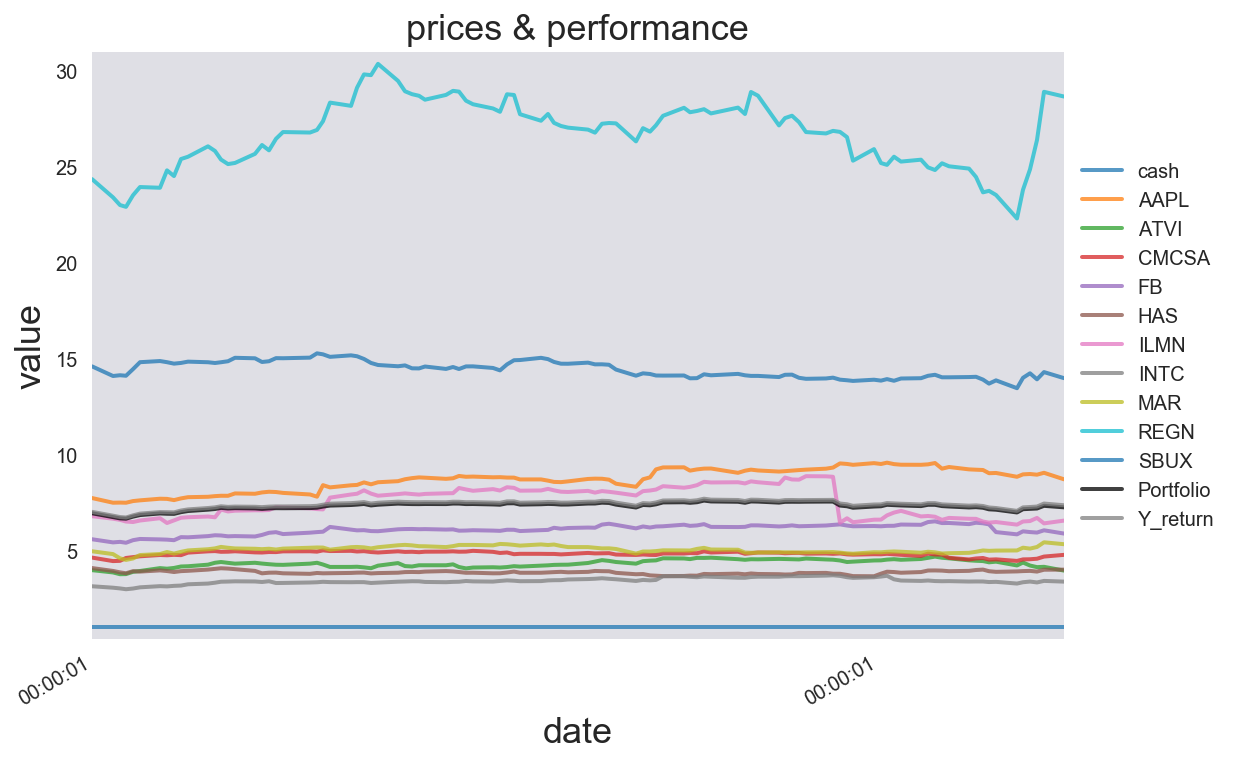

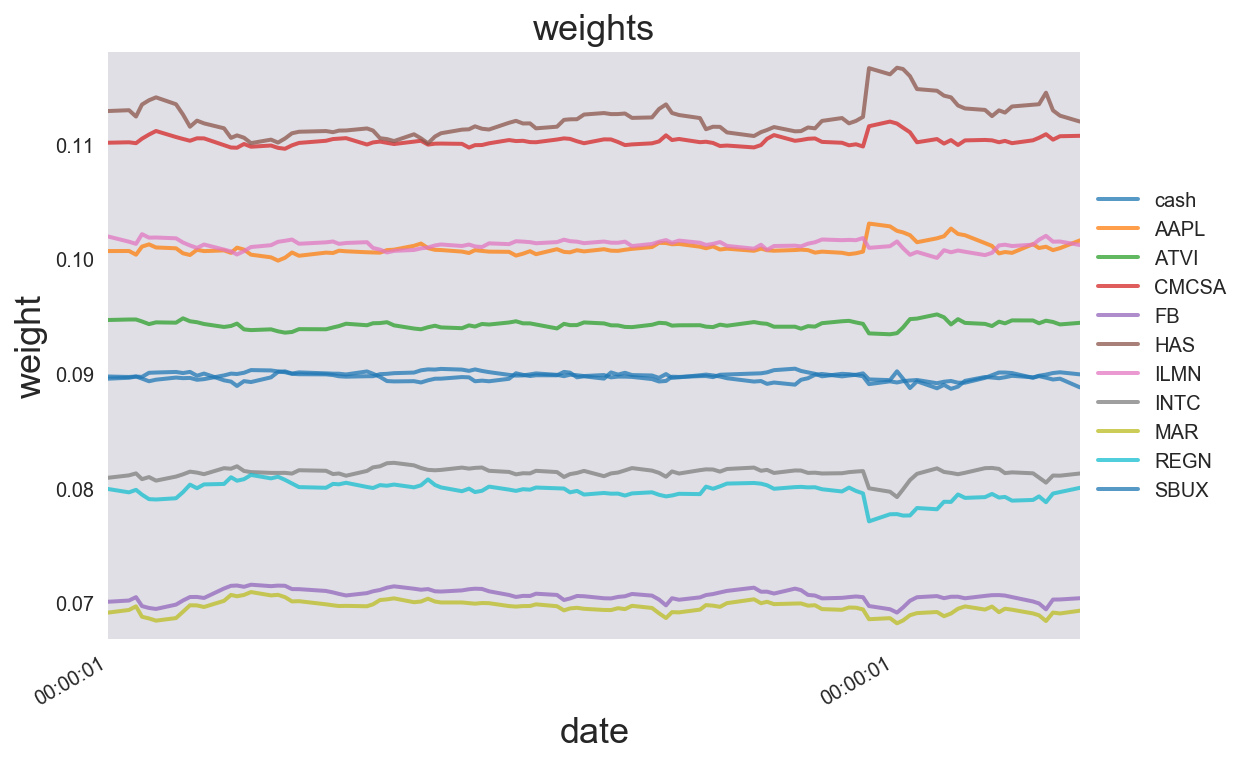

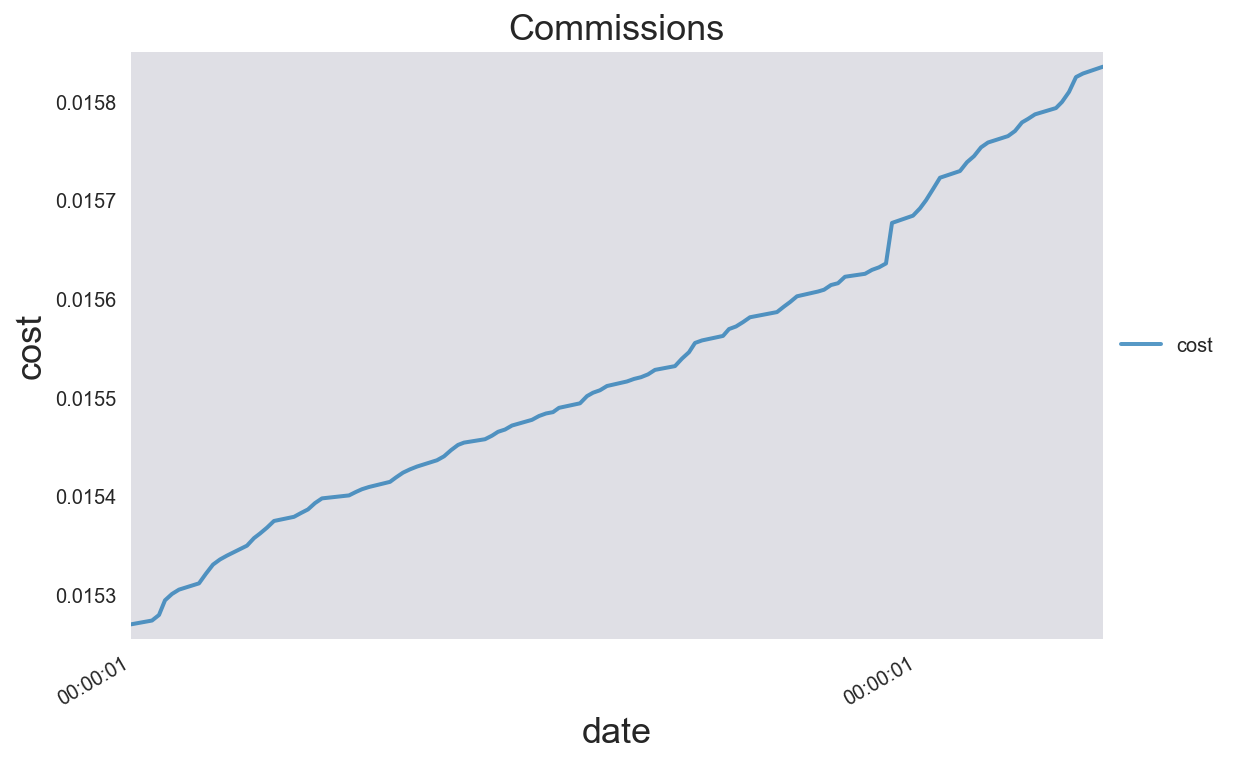

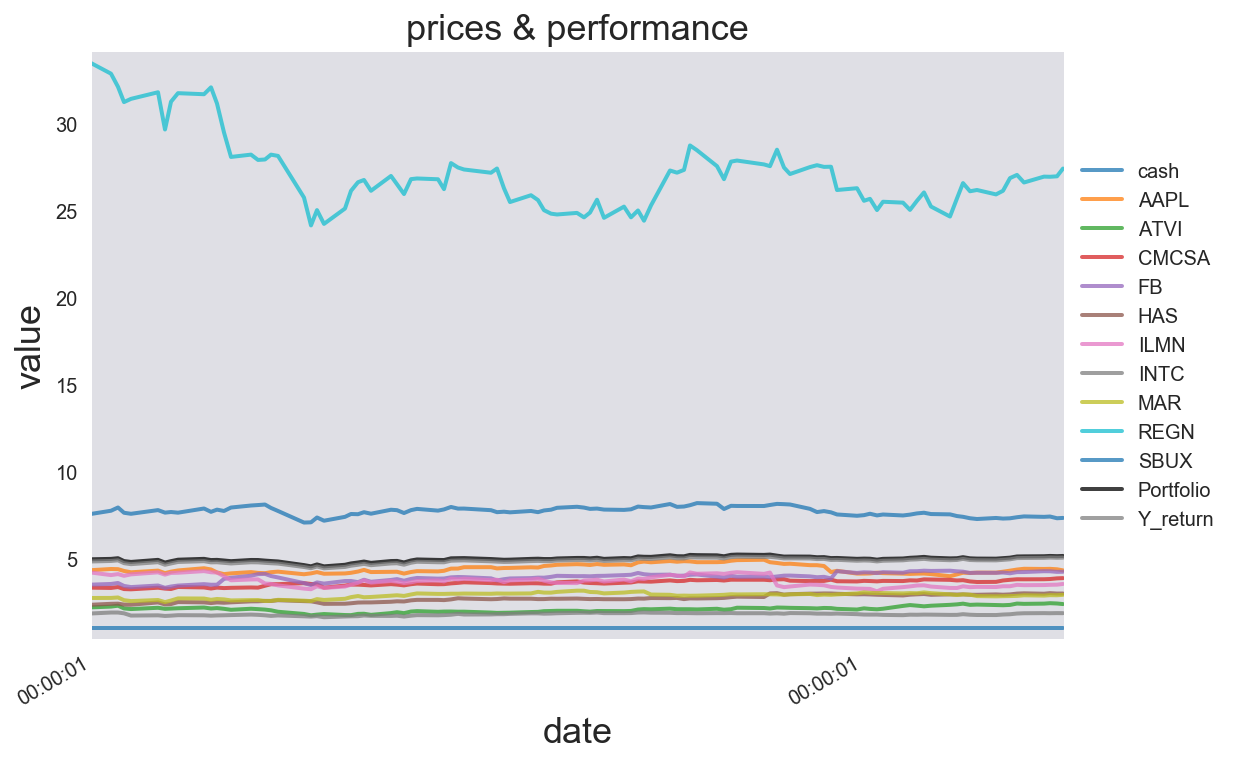

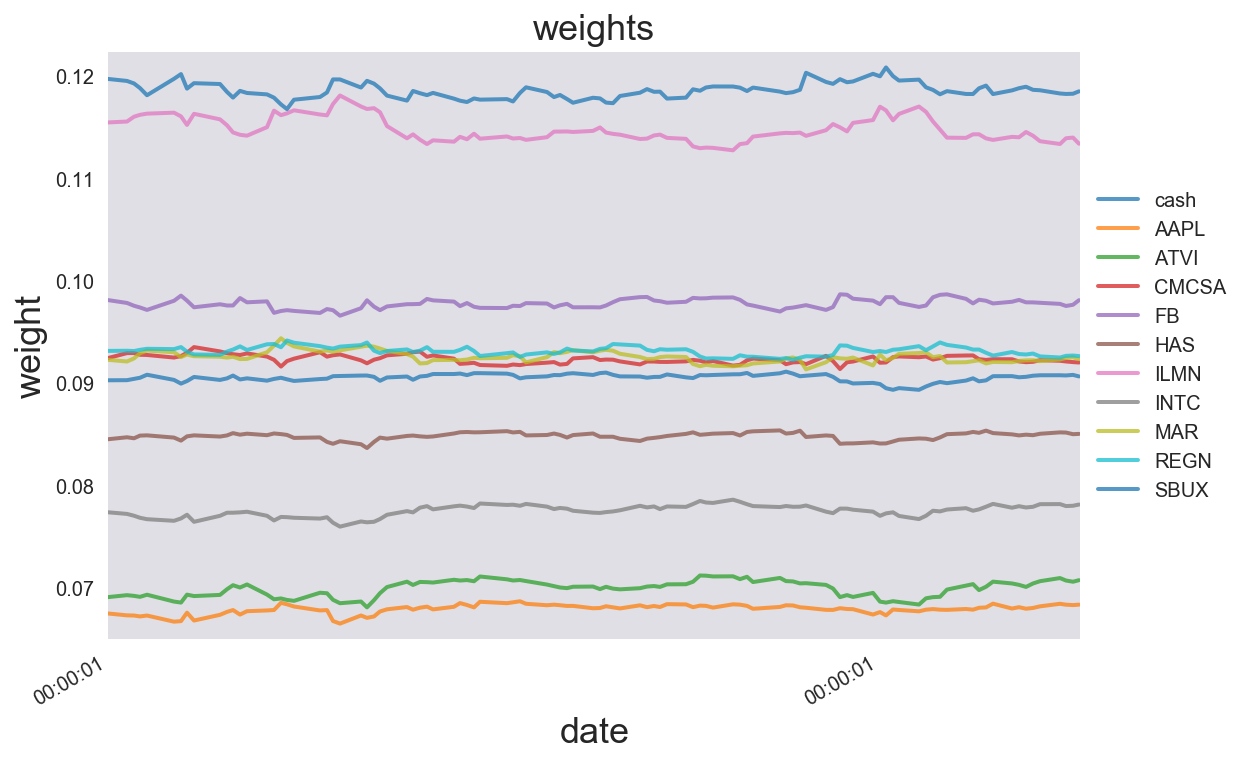

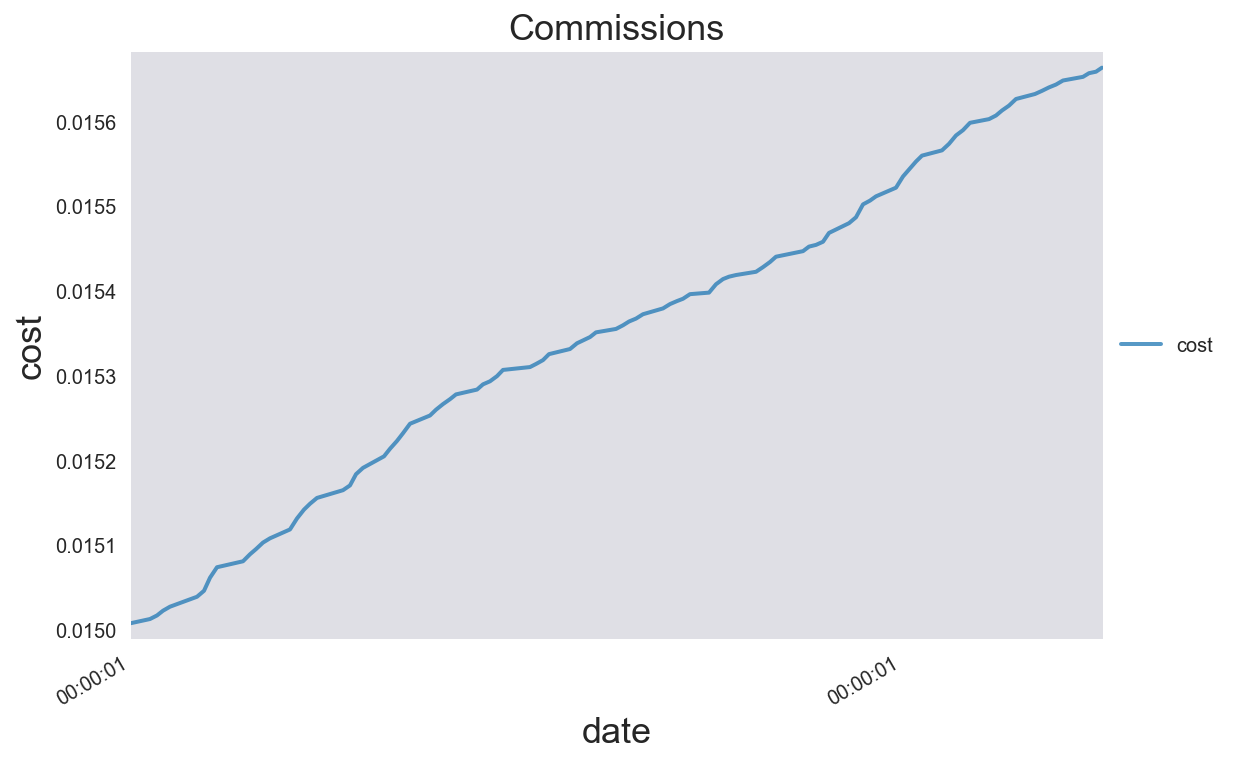

In [12]:
for predictor_type in predictor_list:
    for use_batch_norm in batch_norm_list:
        for window_length in window_length_list:

            # setup environment
            num_training_time = 2000
            env = PortfolioEnv(start_date, end_date,
                               window_length,
                               tickers_list, features_list, batch_size=num_training_time)

            # variable_scope ="ddpg"
            action_dim = env.action_space.shape[0]
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = 'aws2/'+get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = 'aws2/'+get_result_path(window_length, predictor_type, use_batch_norm)

            tf.reset_default_graph()
            sess = tf.Session()

            with sess.as_default():
                # Missing this was the source of one of the most challenging an insidious bugs that I've ever encountered.
                # it was impossible to save the model.
                K.set_session(sess)

                ddpg_model = DDPG2(env, sess, actor_noise, action_dim=action_dim, obs_normalizer="history",
                                   predictor_type=predictor_type, use_batch_norm=use_batch_norm,
                                   model_save_path= model_save_path, summary_path=summary_path)
                ddpg_model.initialize(load_weights=True)
                observation = env.reset()
                done= False
                while not done:
                    action = ddpg_model.predict_single(observation)
                    observation, reward, done, infos = env.step(action)
                    #print(infos['date'],infos['portfolio_value'], infos['market_value'], infos['weight_cash'], infos['weight_AAPL'])
                #df = env.df_info()
                #print(df.iloc[-1,:])
                #print(df.describe())
                env.render(mode='notebook')

After conv2d: (?, 17, 13, 32)
Output: (?, 7072)
After conv2d: (?, 17, 13, 32)
Output: (?, 7072)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state_input (InputLayer)     (None, 17, 15, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 15, 32)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 13, 32)        3104      
_________________________________________________________________
root_network (Flatten)       (None, 7072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                452672    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
______________________________________________

INFO:tensorflow:Summary name Actor Critic Grad is illegal; using Actor_Critic_Grad instead.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_input (InputLayer)        (None, 17, 15, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 17, 15, 32)   416         state_input[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 17, 13, 32)   3104        conv2d_1[0][0]                   
__________________________________________________________________________________________________
root_network (Flatten)          (None, 7072)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_5 (D

INFO:tensorflow:Restoring parameters from weights/ddpg/ddpg2.ckpt


Loading conv2d/kernel:0 from checkpoint. Name: conv2d/kernel
Loading conv2d/bias:0 from checkpoint. Name: conv2d/bias
Loading conv2d_1/kernel:0 from checkpoint. Name: conv2d_1/kernel
Loading conv2d_1/bias:0 from checkpoint. Name: conv2d_1/bias
Loading conv2d_2/kernel:0 from checkpoint. Name: conv2d_2/kernel
Loading conv2d_2/bias:0 from checkpoint. Name: conv2d_2/bias
Loading conv2d_3/kernel:0 from checkpoint. Name: conv2d_3/kernel
Loading conv2d_3/bias:0 from checkpoint. Name: conv2d_3/bias
Loading dense/kernel:0 from checkpoint. Name: dense/kernel
Loading dense/bias:0 from checkpoint. Name: dense/bias
Loading dense_1/kernel:0 from checkpoint. Name: dense_1/kernel
Loading dense_1/bias:0 from checkpoint. Name: dense_1/bias
Loading actor_out/kernel:0 from checkpoint. Name: actor_out/kernel
Loading actor_out/bias:0 from checkpoint. Name: actor_out/bias
Loading Adam/iterations:0 from checkpoint. Name: Adam/iterations
Loading Adam/lr:0 from checkpoint. Name: Adam/lr
Loading Adam/beta_1:0 fr

---found top indice : (array([5]),)
---found top indice : (array([5]),)


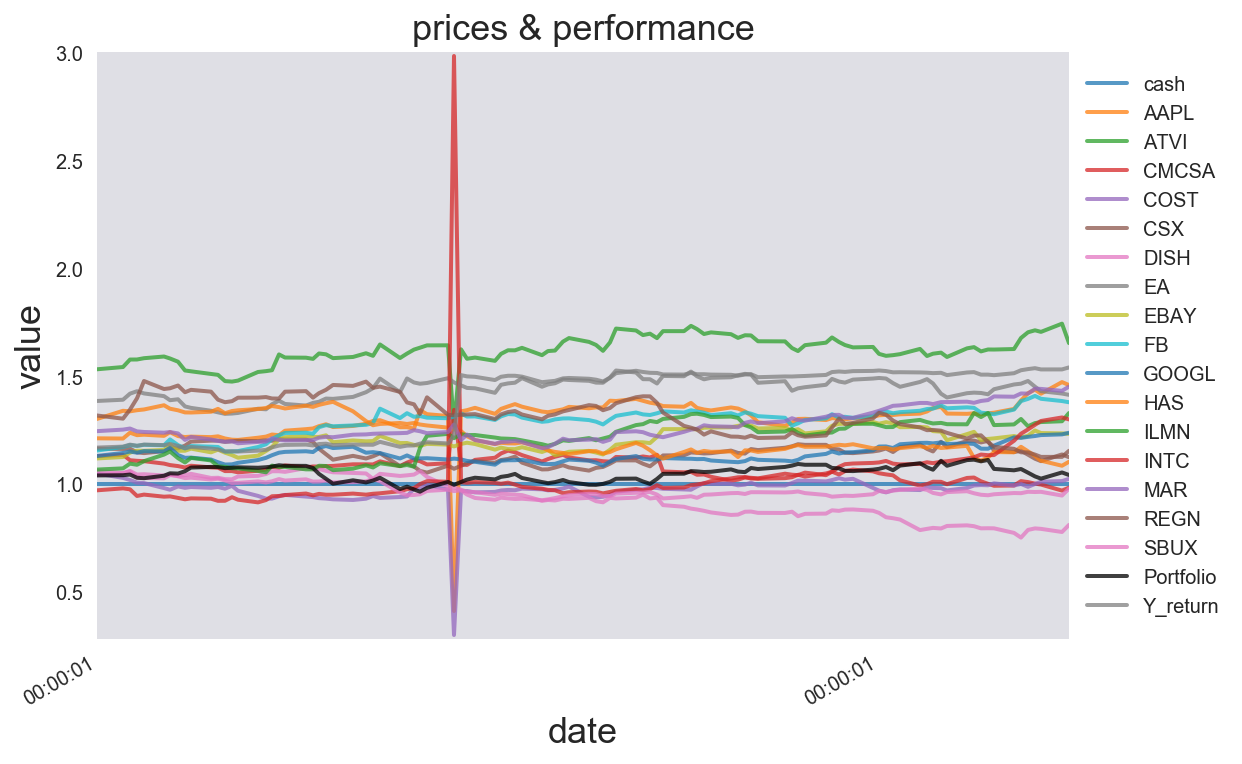

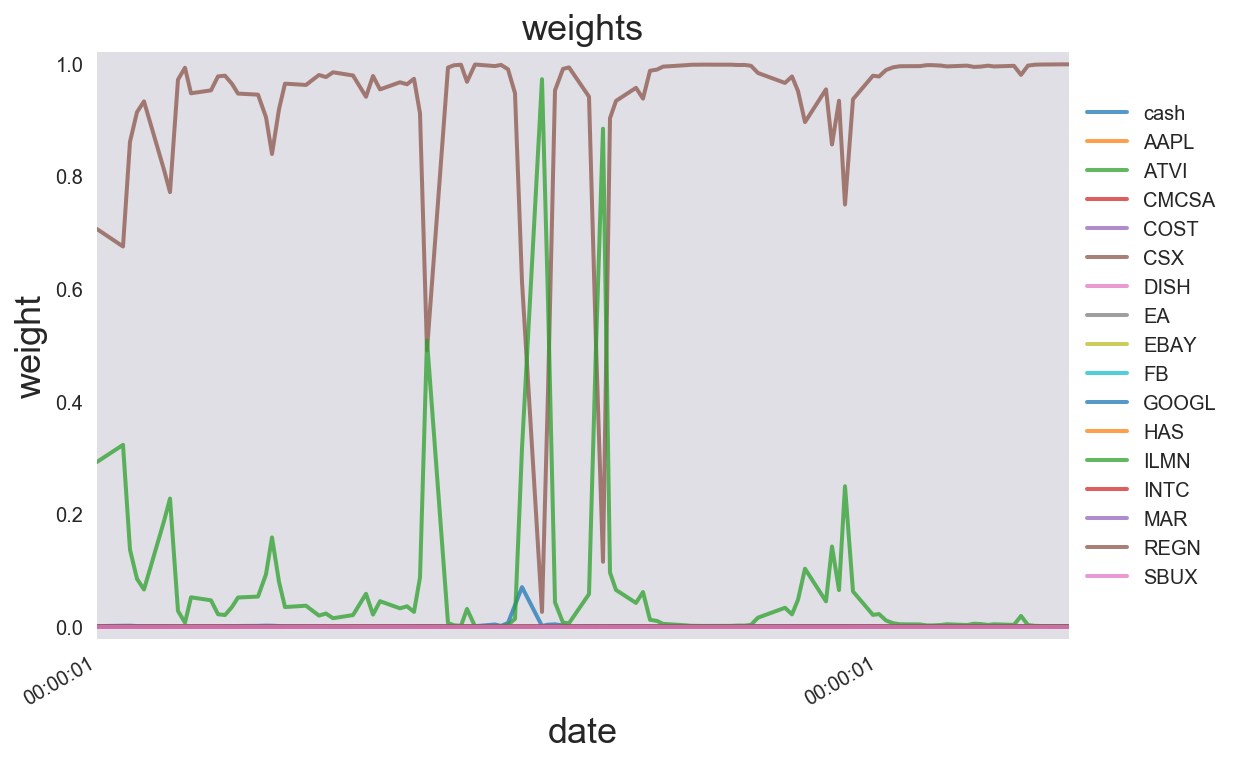

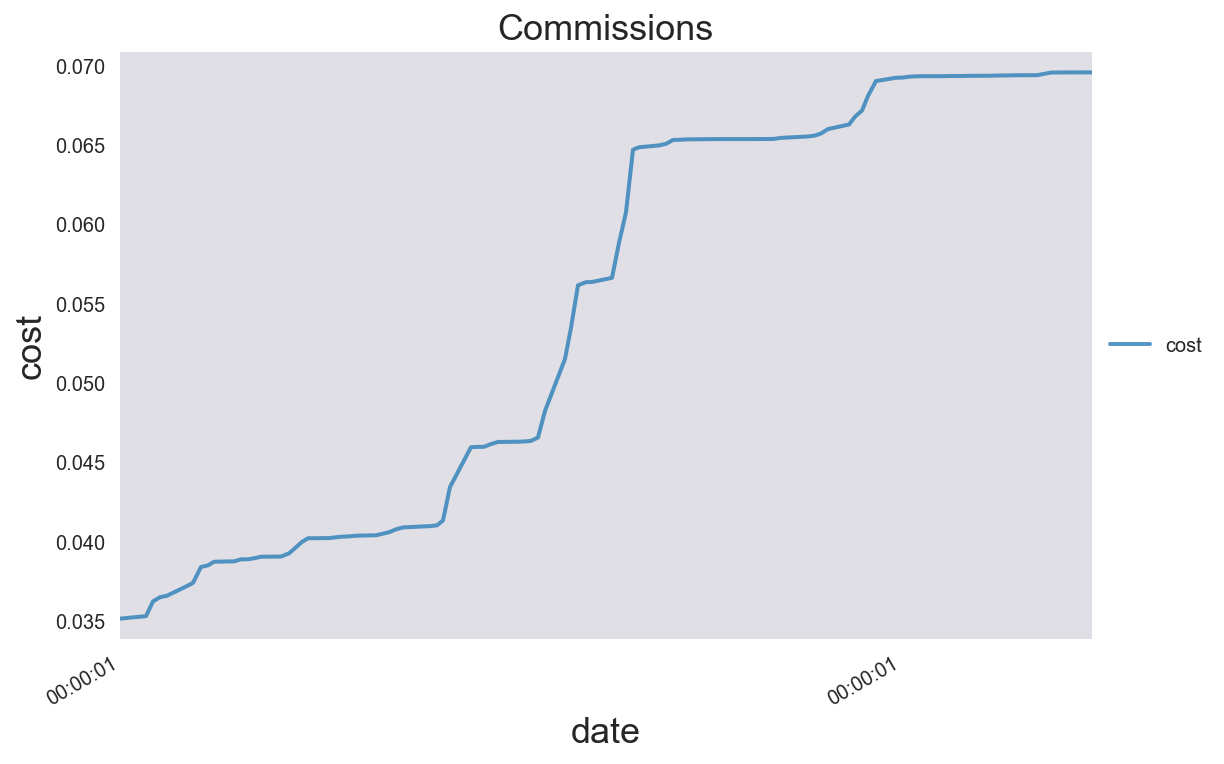

In [24]:
tf.reset_default_graph()
sess = tf.Session()

with sess.as_default():
    # setup environment
    num_training_time = 200
    env = PortfolioEnv(start_date, end_date,
                       window_length,
                       tickers_list, features_list, batch_size=num_training_time, buffer_bias_ratio=0.0)

    #variable_scope ="ddpg"
    action_dim = env.action_space.shape[0]
    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))
    
    K.set_session(sess)
    ddpg_model = DDPG2(env, sess, None, action_dim=action_dim, obs_normalizer="history",
                                   predictor_type='cnn', use_batch_norm=False)
    ddpg_model.initialize(load_weights=True)
    observation = env.reset()
    done= False
    while not done:
        action = ddpg_model.predict_single(observation)
        observation, reward, done, infos = env.step(action)
        #print(infos['date'],infos['portfolio_value'], infos['market_value'], infos['weight_cash'], infos['weight_AAPL'])
    #df = env.df_info()
    #print(df.iloc[-1,:])
    #print(df.describe())
    env.render(mode='notebook')

In [14]:
ddpg_model.initialize(load_weights=True)

INFO:tensorflow:Restoring parameters from aws2/weights/stock/dense/window_15/batch_norm/checkpoint.ckpt


INFO:tensorflow:Restoring parameters from aws2/weights/stock/dense/window_15/batch_norm/checkpoint.ckpt


Build model from scratch


Traceback (most recent call last):
  File "/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1322, in _do_call
    return fn(*args)
  File "/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1307, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1409, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.NotFoundError: Key Adam_5/beta_1 not found in checkpoint
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]

During handling of the above exception, another exception occurred:

Traceback (mos

In [11]:
!ls 'aws2'

results   weights   weights-1


In [33]:
# read the data and choose the target stocks for training a toy example
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]
num_training_time = history.shape[1]
num_testing_time = history.shape[1]
window_length = 3

In [34]:
# get target history
target_stocks = ['AAPL', 'COST', 'DISH']
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

In [35]:
target_history.shape
target_history

array([[[ 89.06,  90.  ,  89.04,  90.  ],
        [ 90.27,  91.23,  90.03,  90.24],
        [ 90.19,  90.57,  89.68,  90.12],
        ...,
        [159.26, 161.27, 159.11, 161.06],
        [159.9 , 160.  , 154.63, 155.32],
        [156.6 , 158.57, 156.07, 157.48]],

       [[ 95.08,  95.63,  94.84,  95.63],
        [ 96.  ,  96.  ,  95.37,  95.67],
        [ 95.84,  96.89,  95.51,  96.47],
        ...,
        [157.14, 157.57, 156.2 , 156.86],
        [156.17, 157.57, 155.37, 156.64],
        [156.51, 157.8 , 156.41, 156.65]],

       [[ 30.89,  31.06,  30.43,  31.01],
        [ 31.11,  31.25,  30.56,  30.63],
        [ 30.55,  31.07,  30.52,  31.05],
        ...,
        [ 59.3 ,  59.92,  58.96,  59.74],
        [ 59.19,  59.62,  58.15,  58.19],
        [ 58.41,  58.66,  58.02,  58.46]]])

In [36]:
# collect testing data
testing_stocks = ['CMCSA', 'GOOGL', 'EBAY']
testing_history = np.empty(shape=(len(testing_stocks), num_testing_time, history.shape[2]))
for i, stock in enumerate(target_stocks):
    testing_history[i] = history[abbreviation.index(stock), :num_testing_time, :]

In [37]:
# dataset for 16 stocks by splitting timestamp
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]

# 16 stocks are all involved. We choose first 3 years as training data
num_training_time = 1095
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# and last 2 years as testing data.
testing_stocks = abbreviation
testing_history = np.empty(shape=(len(testing_stocks), history.shape[1] - num_training_time, 
                               history.shape[2]))
for i, stock in enumerate(testing_stocks):
    testing_history[i] = history[abbreviation.index(stock), num_training_time:, :]

In [38]:
nb_classes = len(target_stocks) + 1
print(target_history.shape)
print(testing_history.shape)

(16, 1095, 4)
(16, 730, 4)


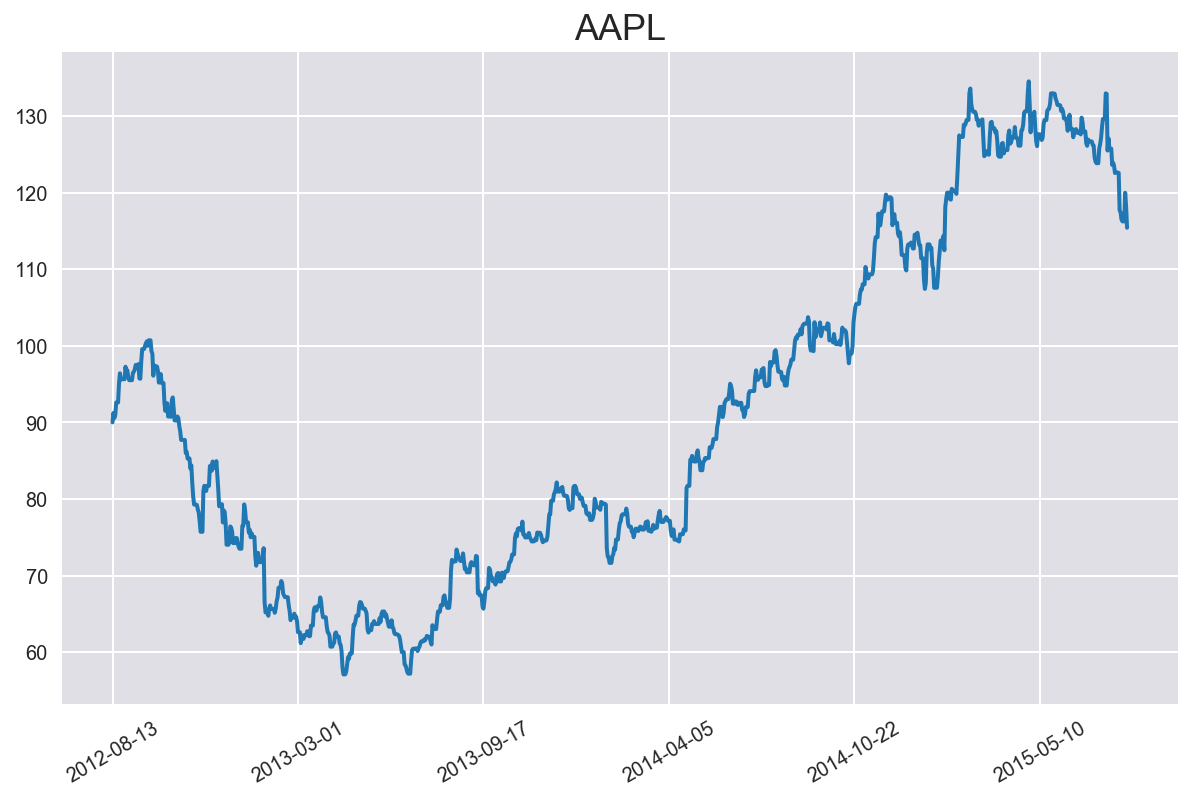

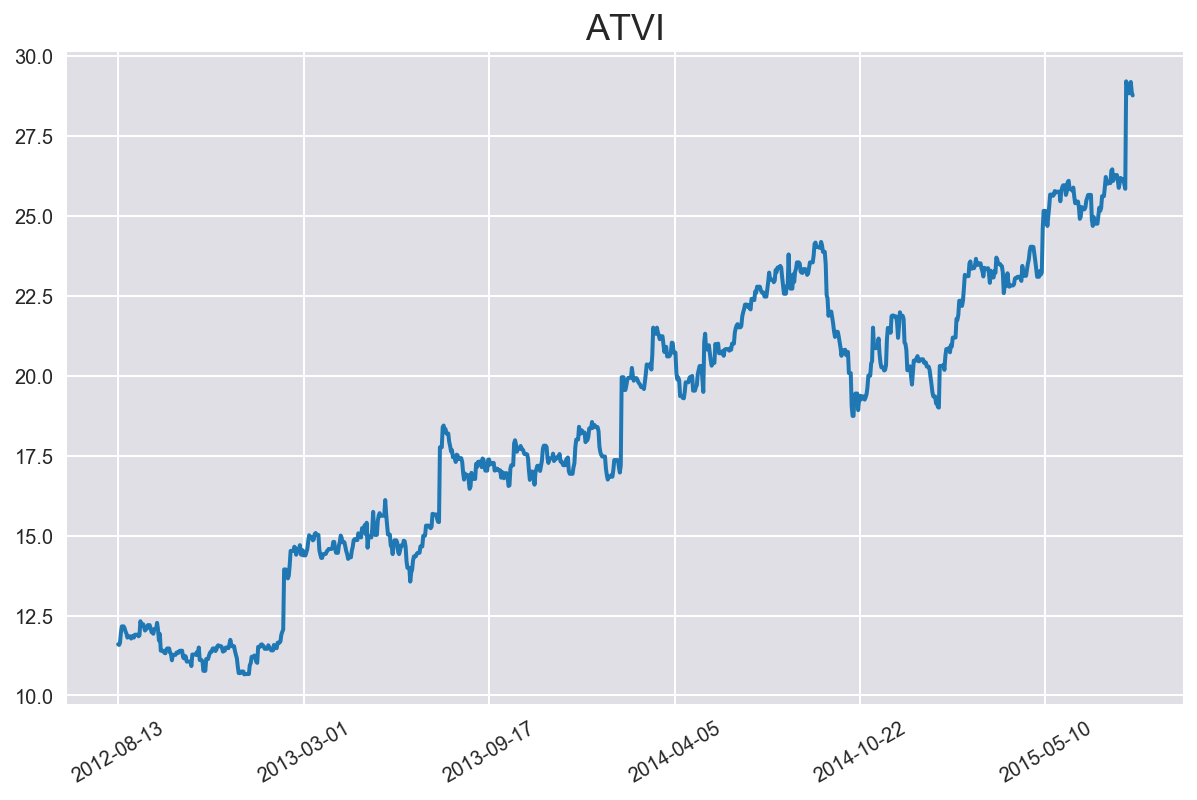

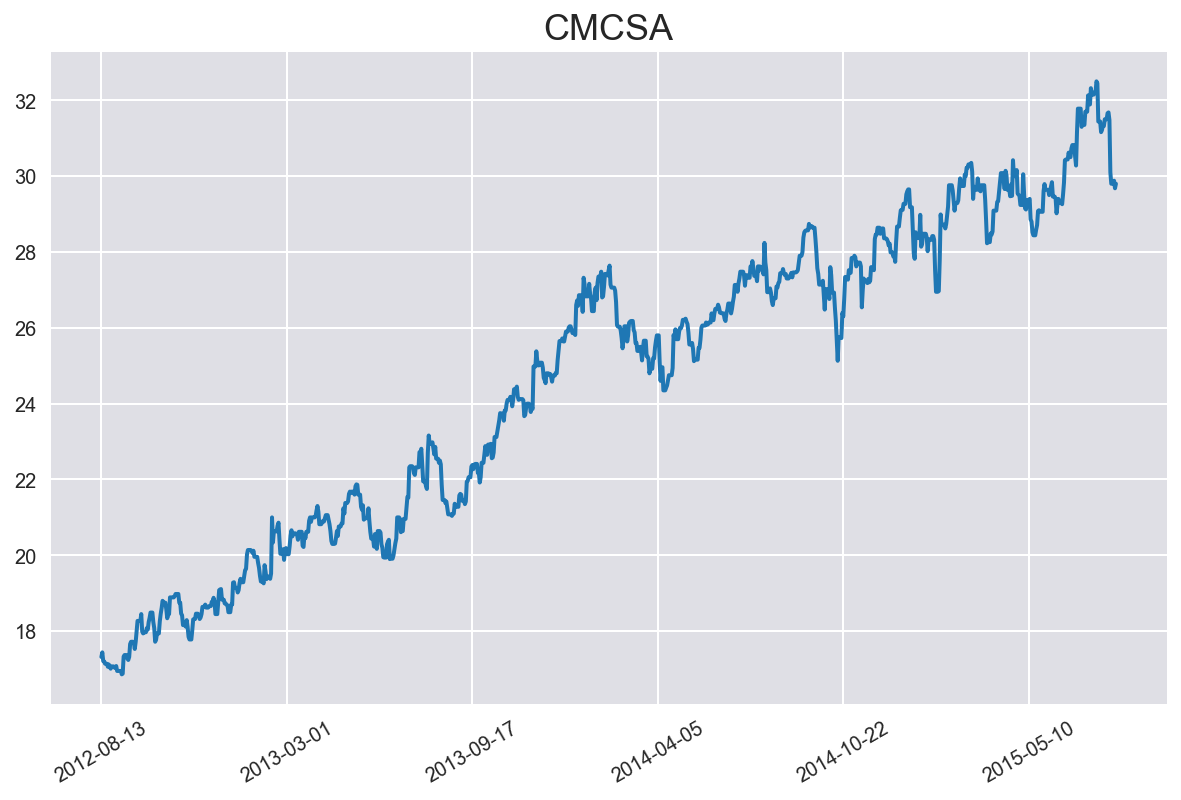

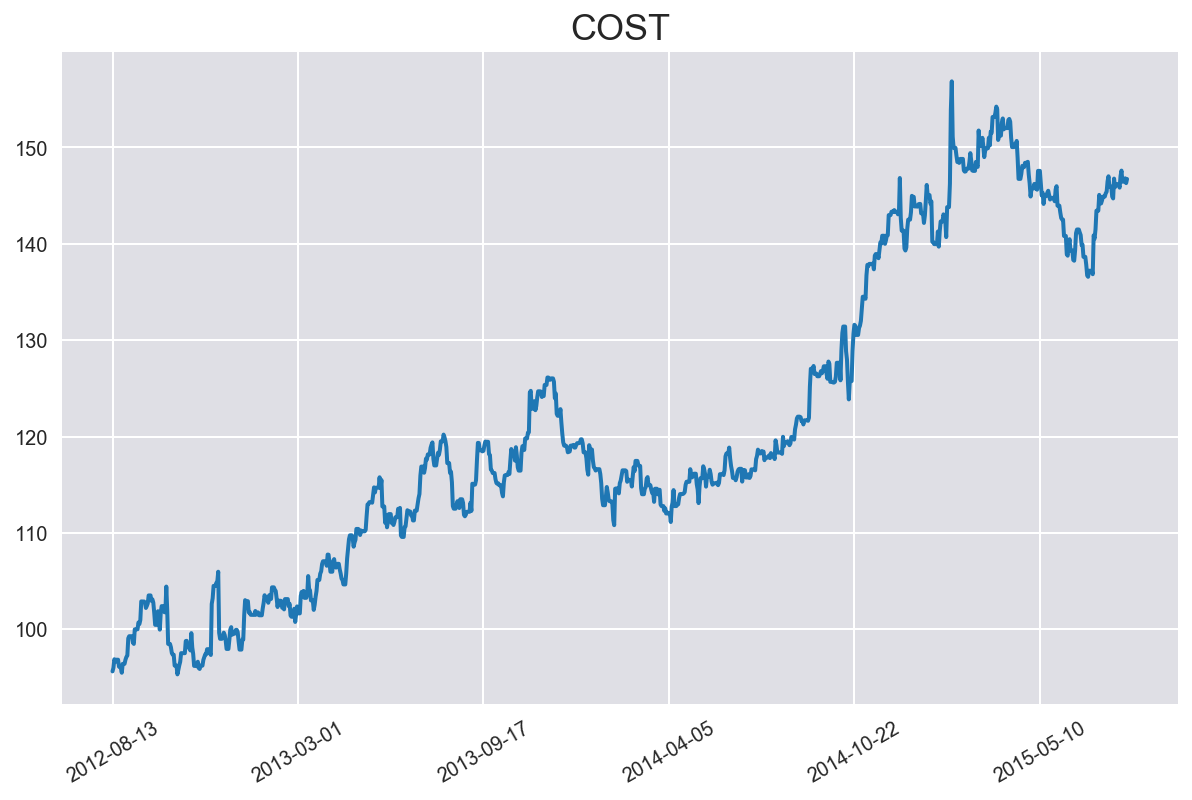

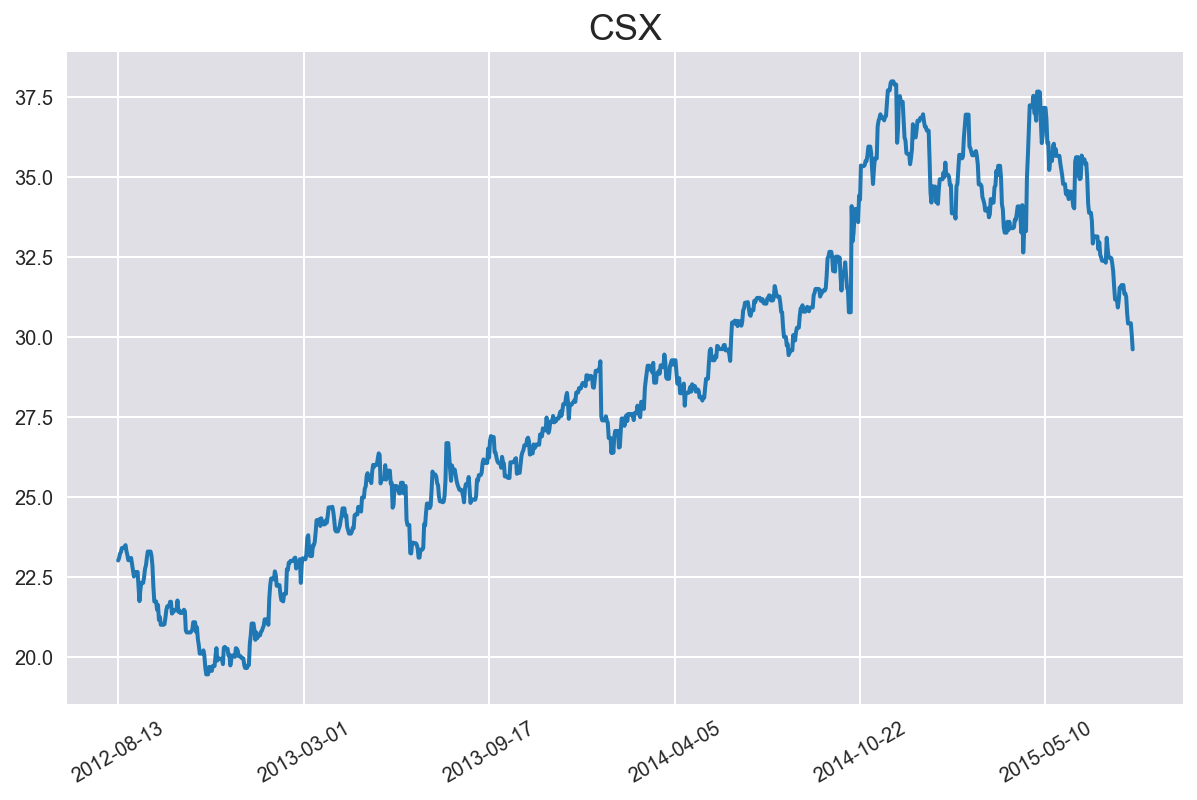

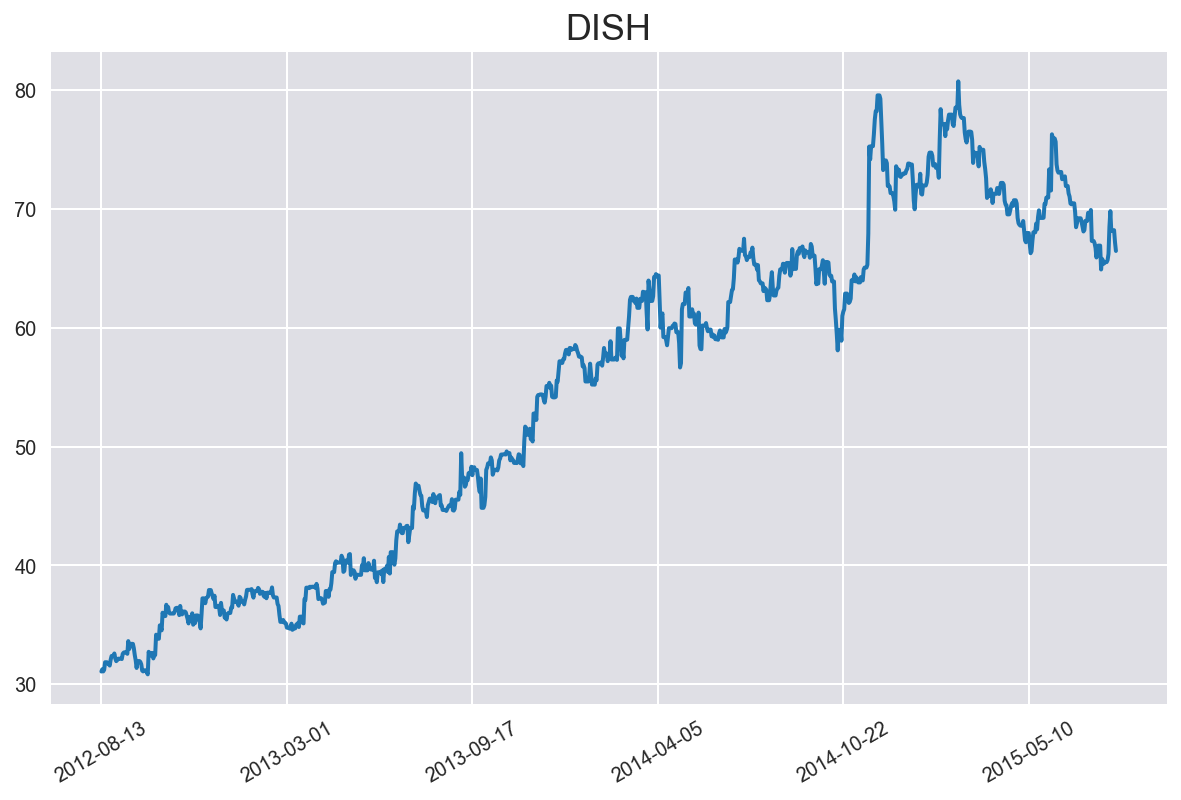

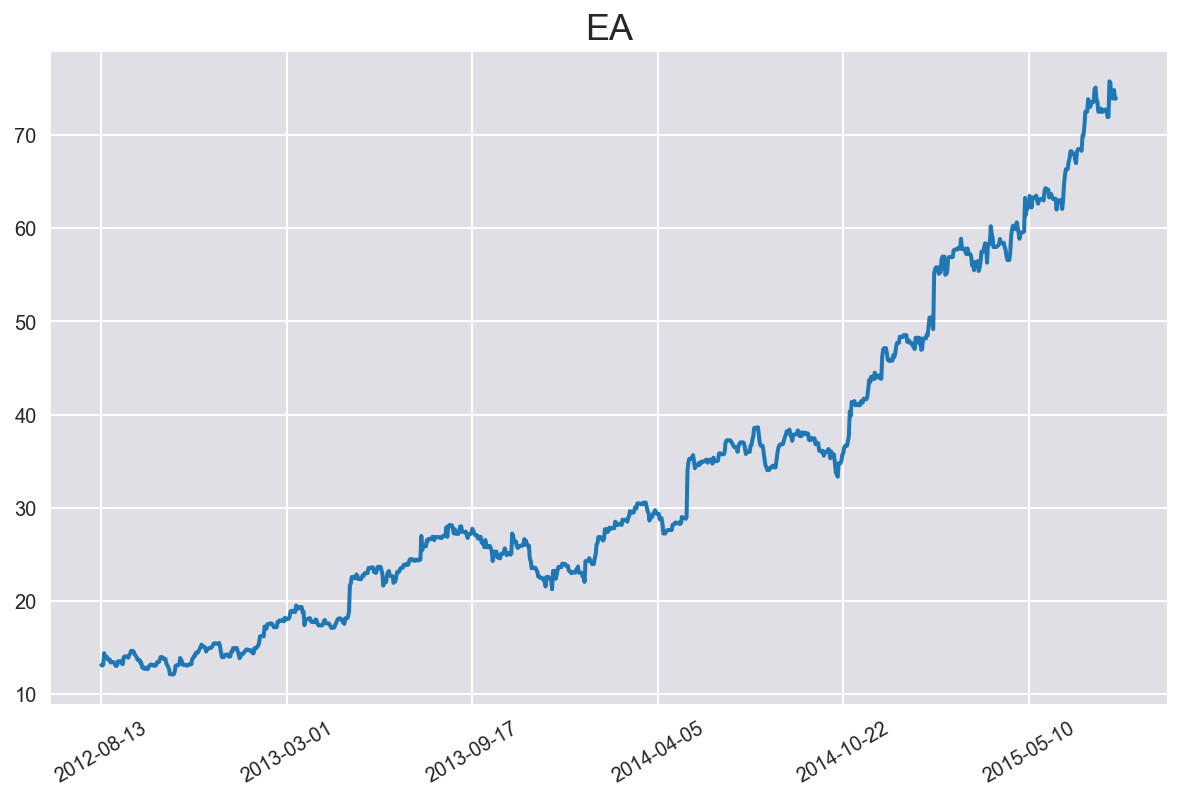

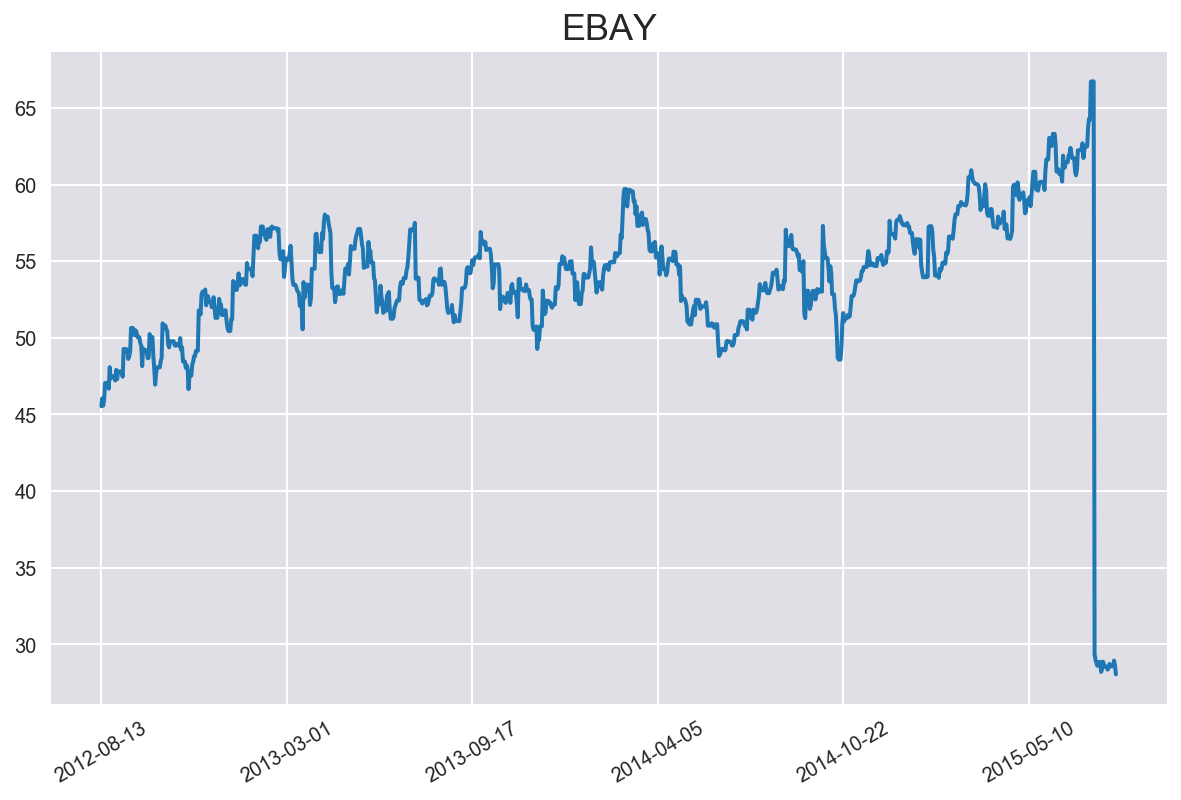

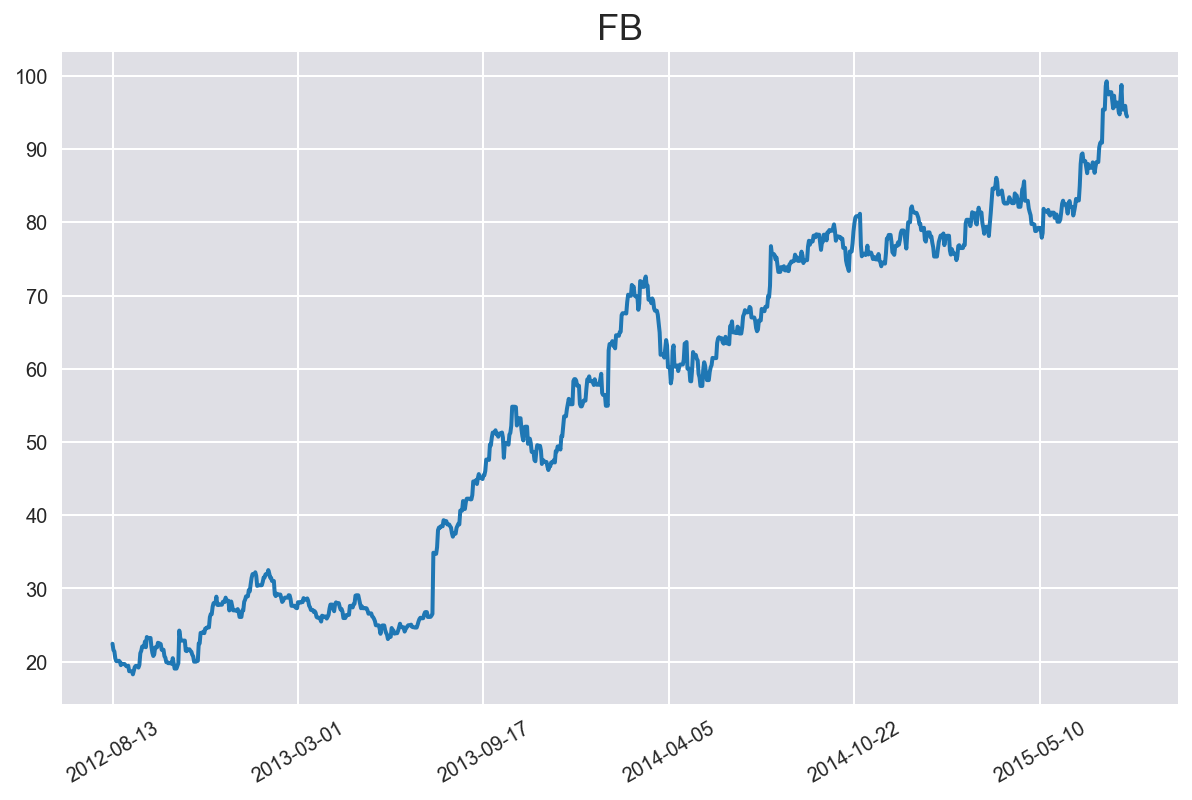

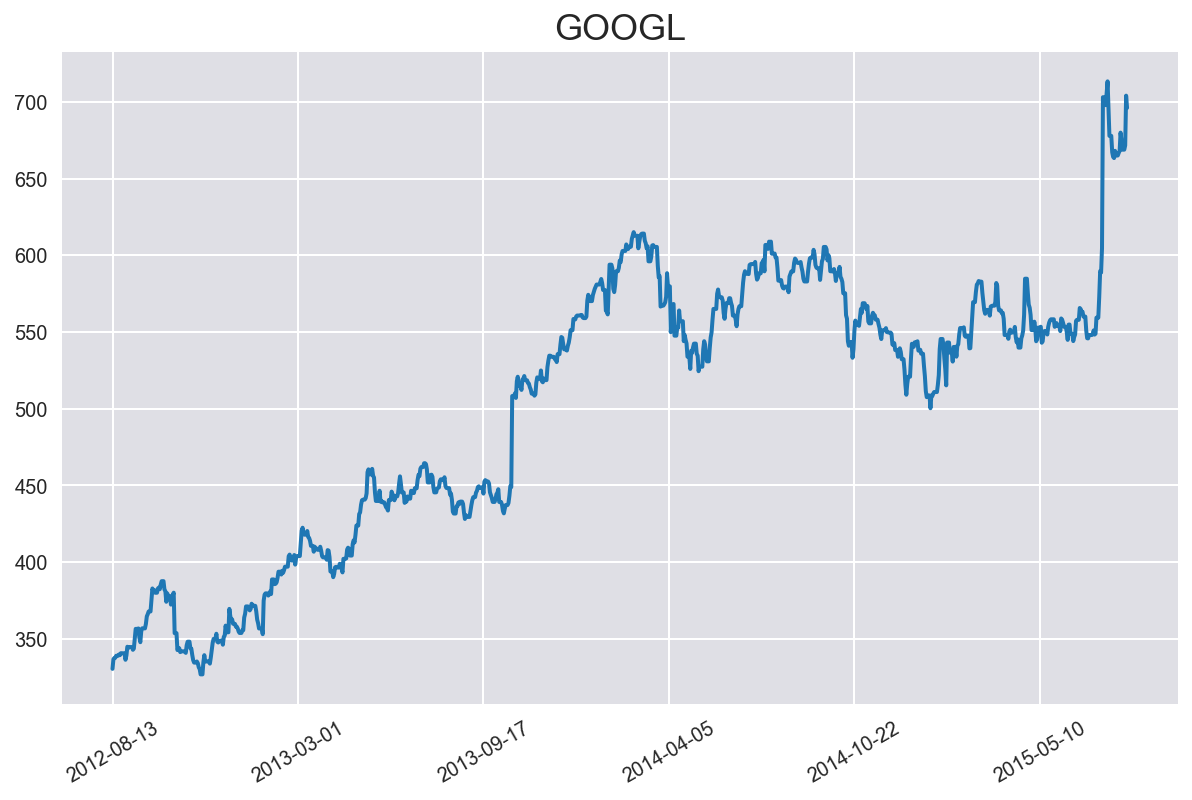

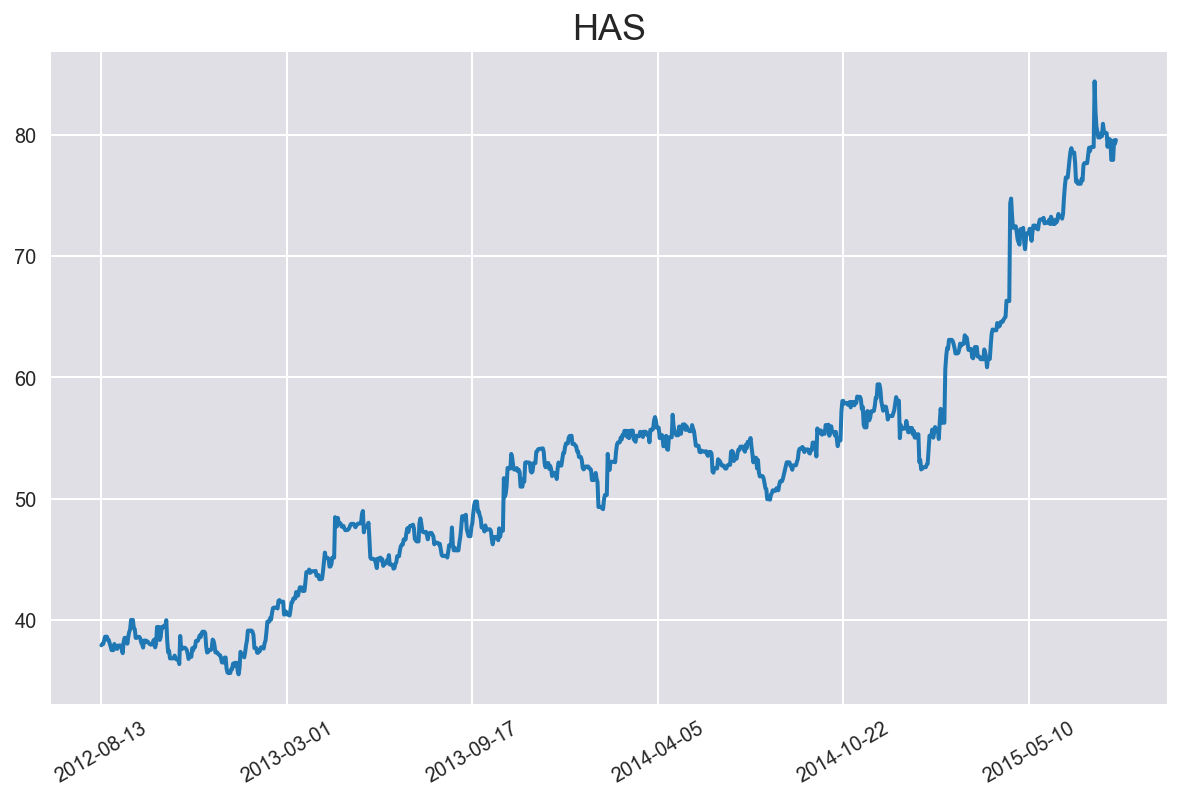

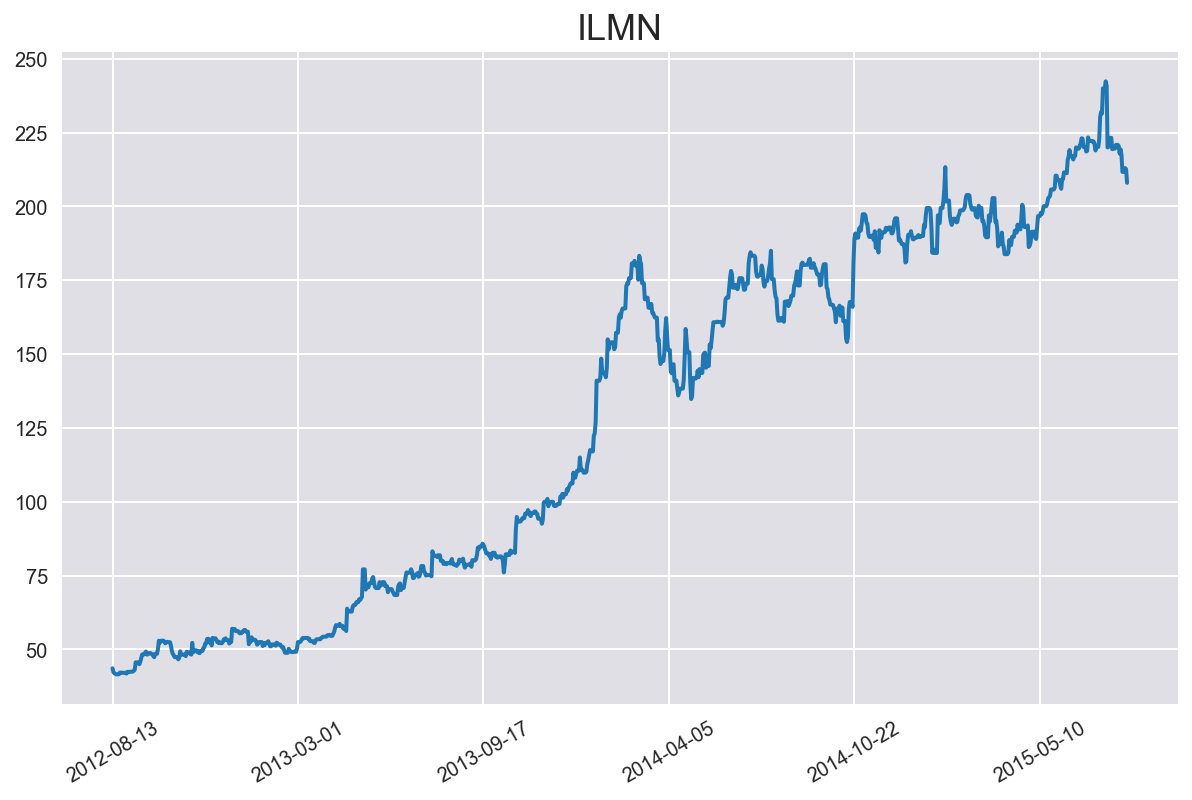

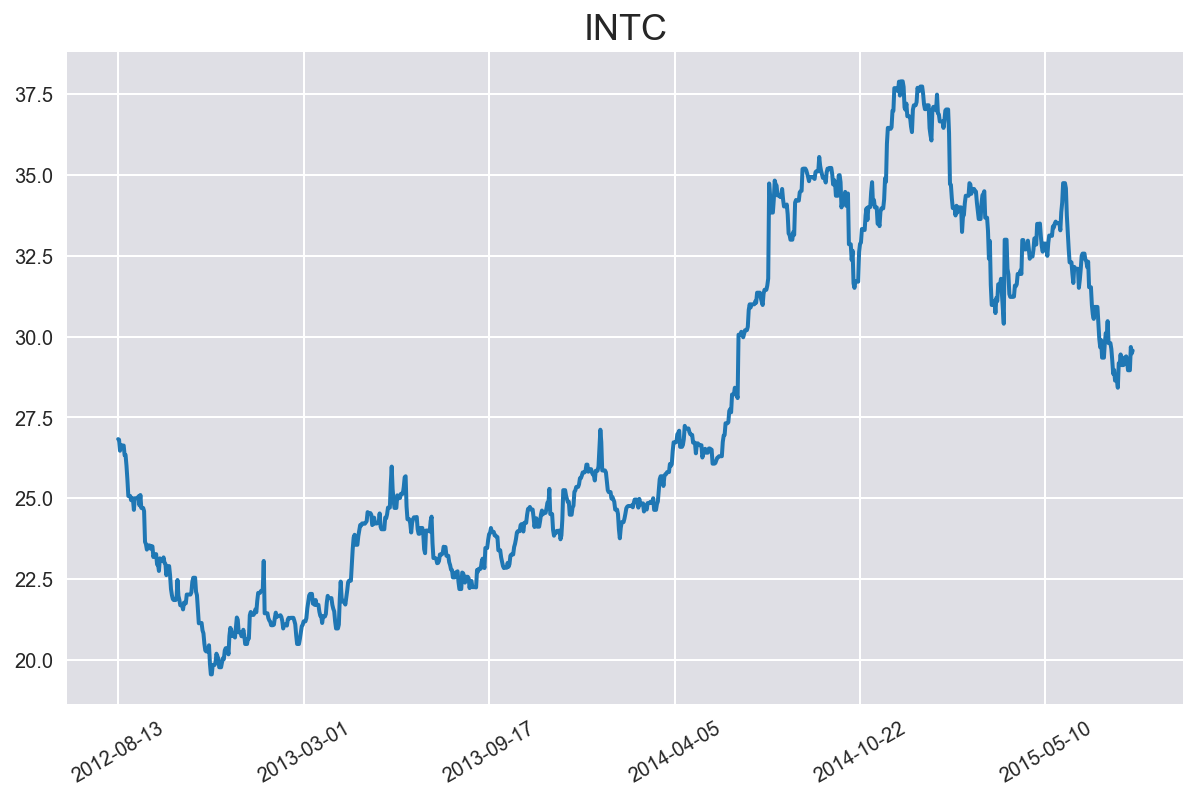

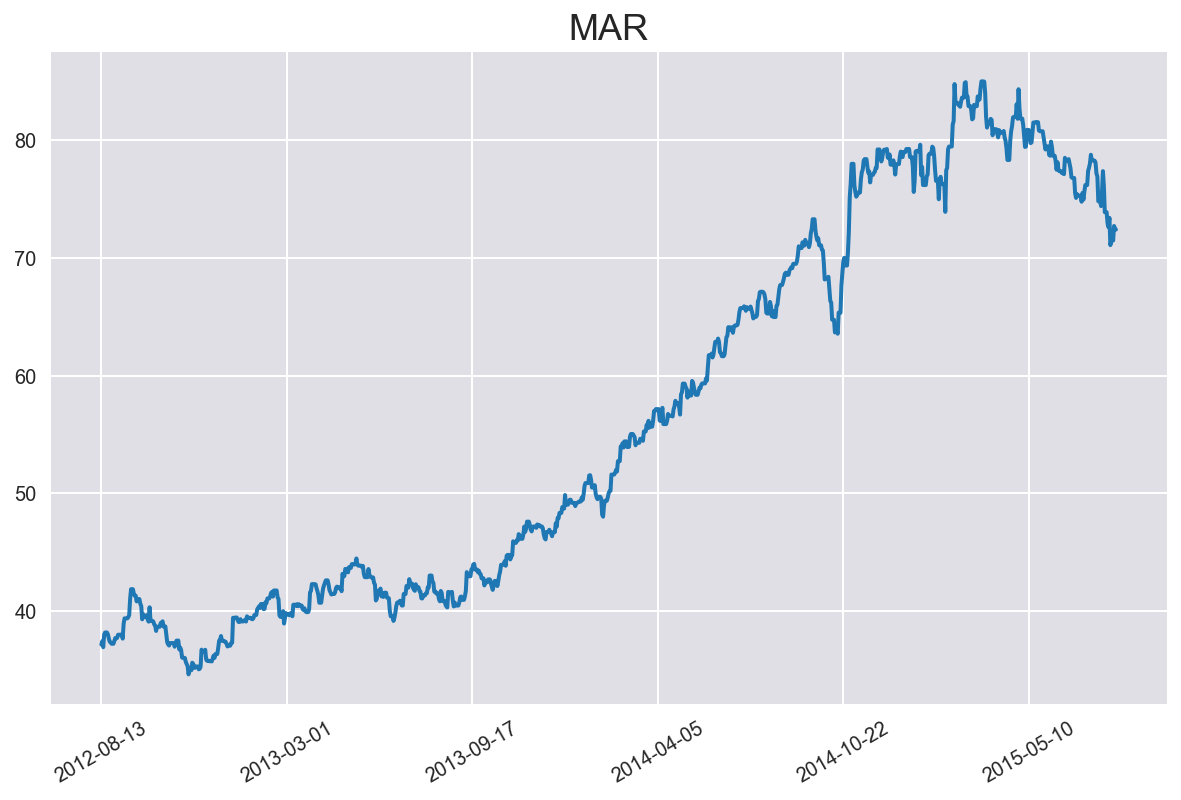

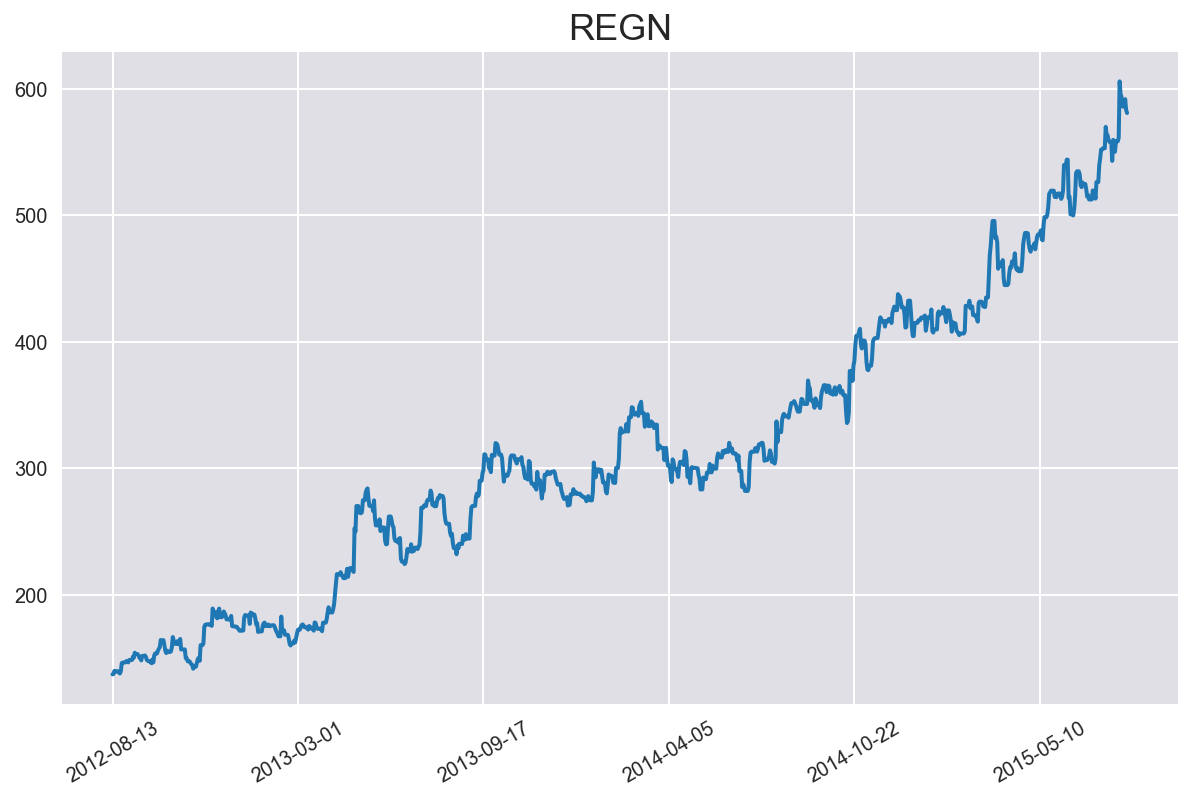

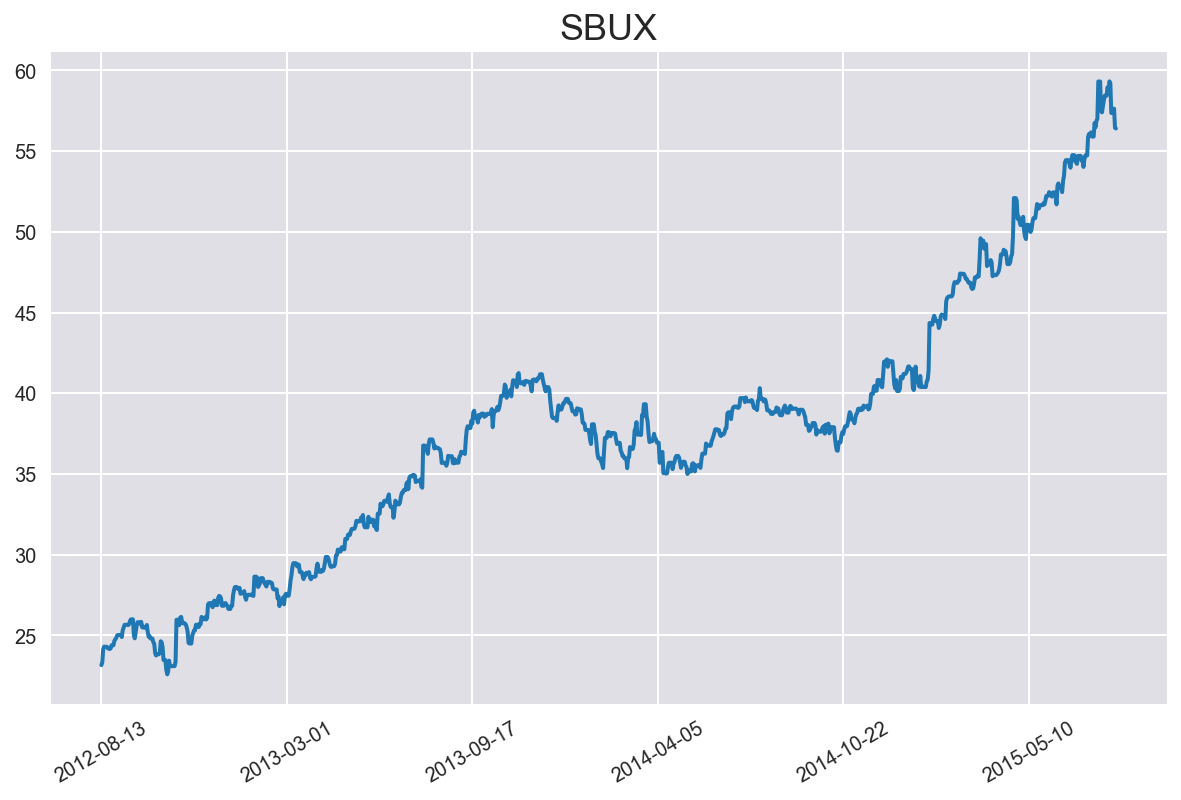

In [17]:
# visualize 3 stock open price
if True:
    date_list = [index_to_date(i) for i in range(target_history.shape[1])]
    x = range(target_history.shape[1])
    for i in range(len(target_stocks)):
        plt.figure(i)
        plt.plot(x, target_history[i, :, 1])  # open, high, low, close = [0, 1, 2, 3]
        plt.xticks(x[::200], date_list[::200], rotation=30)
        plt.title(target_stocks[i])
        plt.show()

## Load Models

In [10]:
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ddpg.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

import numpy as np
import tflearn
import tensorflow as tf

from stock_trading import StockActor, StockCritic, obs_normalizer, get_model_path, get_result_path, \
                          test_model, get_variable_scope, test_model_multiple
    
from model.supervised.lstm import StockLSTM
from model.supervised.cnn import StockCNN

Using TensorFlow backend.


In [11]:
tf.__version__

'1.8.0'

In [12]:
import keras as keras
keras.__version__

'2.1.6'

In [13]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

In [14]:
models = []
model_names = []
window_length_lst = [3, 7, 14, 21]
predictor_type_lst = ['cnn', 'lstm']
use_batch_norm = True

In [15]:
for window_length in window_length_lst:
    name = 'imit_LSTM%3A window = {}'.format(window_length)
    model_name = 'imitation_lstm_window_{}'.format(window_length)
    model_names.append(model_name)
    # instantiate LSTM model
    lstm_model = StockLSTM(nb_classes, window_length, weights_file = 'weights/' + name + '.h5')
    lstm_model.build_model(load_weights=True)
    models.append(lstm_model)
    
    name = 'imit_CNN%3A window = {}'.format(window_length)
    model_name = 'imitation_cnn_window_{}'.format(window_length)
    model_names.append(model_name)
    # instantiate CNN model
    cnn_model = StockCNN(nb_classes, window_length, weights_file = 'weights/' + name + '.h5')
    cnn_model.build_model(load_weights=True)
    models.append(cnn_model)

/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model
Successfully loaded model


In [16]:
cnn_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 17, 19, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 19, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 1, 32)         19488     
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 1, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 544)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                34880     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

In [17]:
# instantiate environment, 3 stocks, with trading cost, window_length 3, start_date sample each time
for window_length in window_length_lst:
    for predictor_type in predictor_type_lst:
        name = 'DDPG_window_{}_predictor_{}'.format(window_length, predictor_type)
        model_names.append(name)
        tf.reset_default_graph()
        sess = tf.Session()
        tflearn.config.init_training_mode()
        action_dim = [nb_classes]
        state_dim = [nb_classes, window_length]
        variable_scope = get_variable_scope(window_length, predictor_type, use_batch_norm)
        with tf.variable_scope(variable_scope):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, predictor_type, 
                               use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                                 learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                                 predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(window_length, predictor_type, use_batch_norm)
            summary_path = get_result_path(window_length, predictor_type, use_batch_norm)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              config_file='config/stock.json', model_save_path=model_save_path,
                              summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=False)
            models.append(ddpg_model)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
After conv2d: (?, 17, 1, 32)
Output: (?, 544)
NET ACTOR 1  Tensor("cnn_window_3_batch_norm/Flatten/Reshape:0", shape=(?, 544), dtype=float32)
NET ACTOR  Tensor("cnn_window_3_batch_norm/Relu_3:0", shape=(?, 64), dtype=float32)
After conv2d: (?, 17, 1, 32)
Output: (?, 544)
NET ACTOR 1  Tensor("cnn_window_3_batch_norm/Flatten_1/Reshape:0", shape=(?, 544), dtype=float32)
NET ACTOR  Tensor("cnn_window_3_batch_norm/Relu_7:0", shape=(?, 64), dtype=float32)
After conv2d: (?, 17, 1, 32)
Output: (?, 544)
After conv2d: (?, 17, 1, 32)
Output: (?, 544)
INFO:tensorflow:Restoring parameters from weights/stock/cnn/window_3/batch_norm/checkpoint.ckpt
Reshaped input: (?, 3, 1)
After LSTM: (?, 32)
After reshape: (?, 17, 32)
Output: (?, 544)
NET ACTOR 1  Tensor("lstm_window_3_batch_norm/Flatten/Reshape:0", shape=(?, 544), dtype=float32)
NET ACTOR  Tensor("lstm_window_3_batch_norm/R

In [18]:
cnnmodel = models[5]
model_1 = cnnmodel.model
model_1.layers

In [19]:
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[:8], steps=1000, 
                              sample_start_date='2012-10-30')

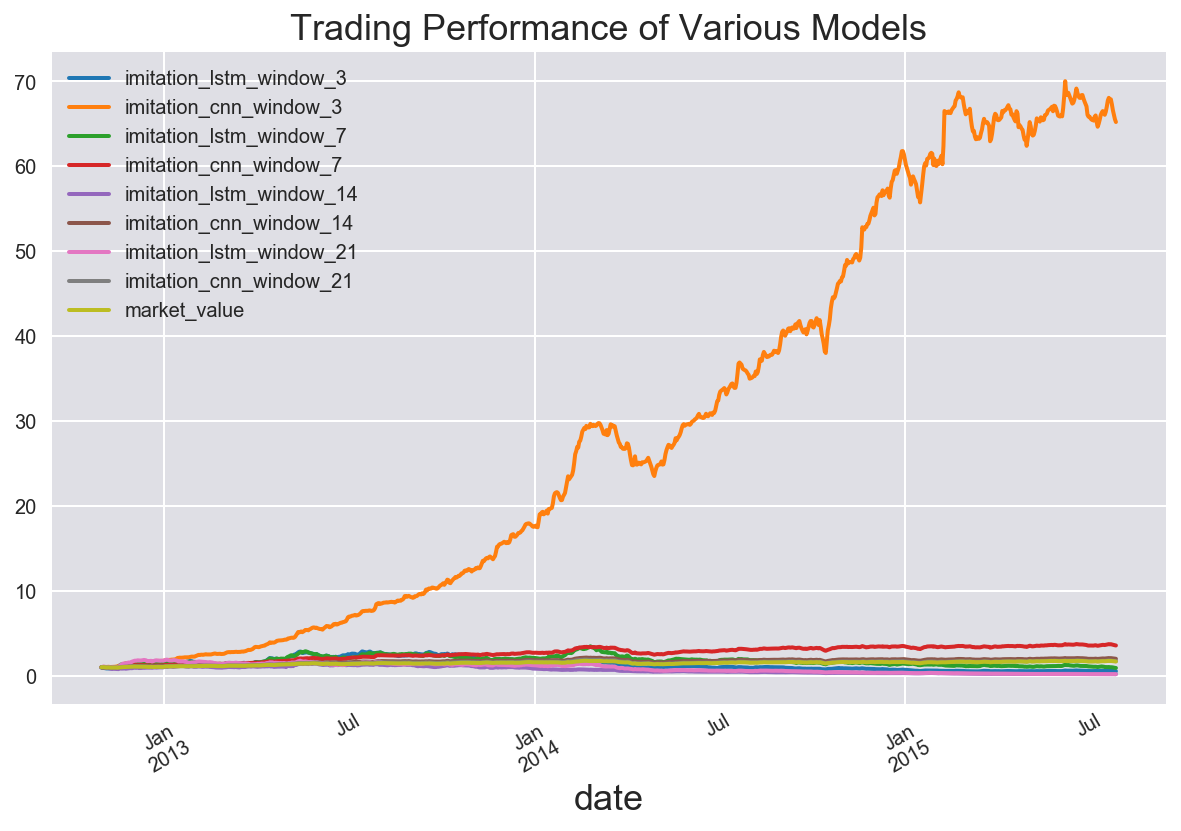

In [20]:
test_model_multiple(env, models[:8])

In [21]:
env = MultiActionPortfolioEnv(target_history, target_stocks, model_names[8:], steps=600, 
                              sample_start_date='2012-10-30')

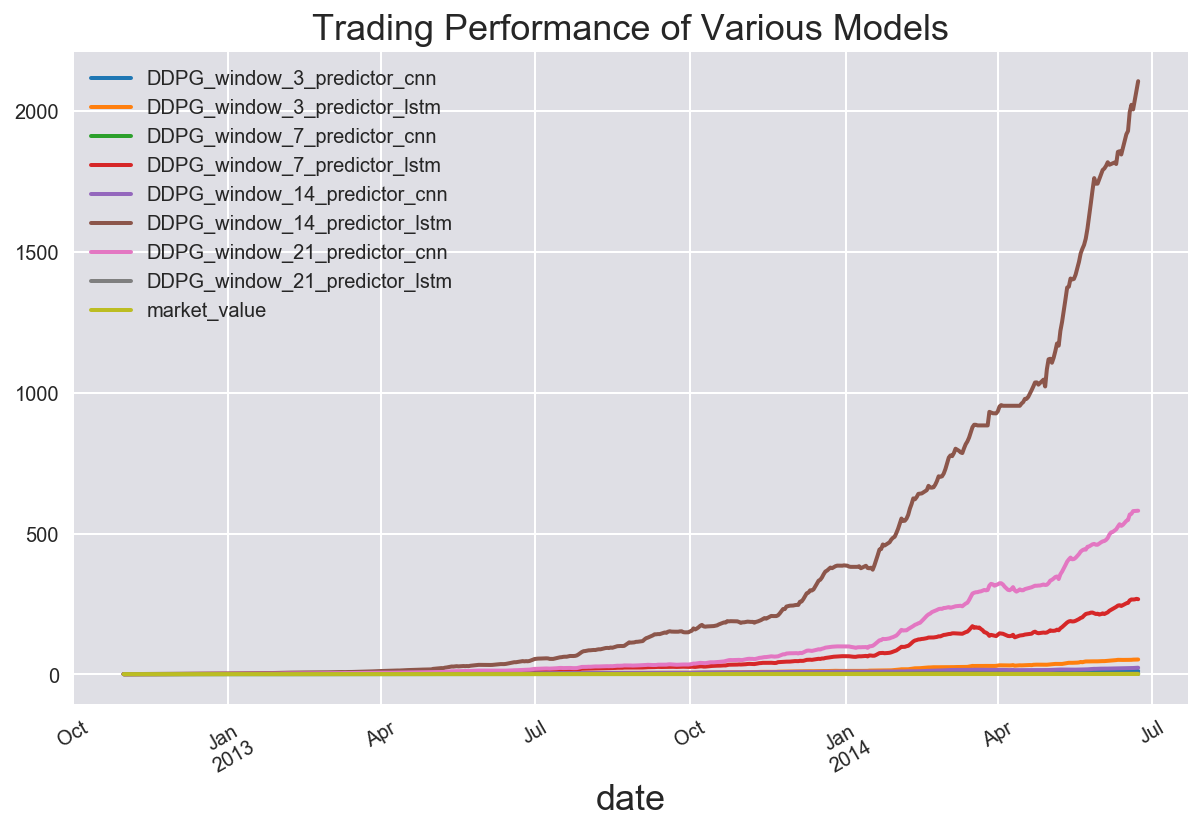

In [22]:
test_model_multiple(env, models[8:])

In [23]:
# evaluate the model with unseen data from same stock, fixed the starting date
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[:8], steps=650, 
                              start_idx=num_training_time, sample_start_date=None)

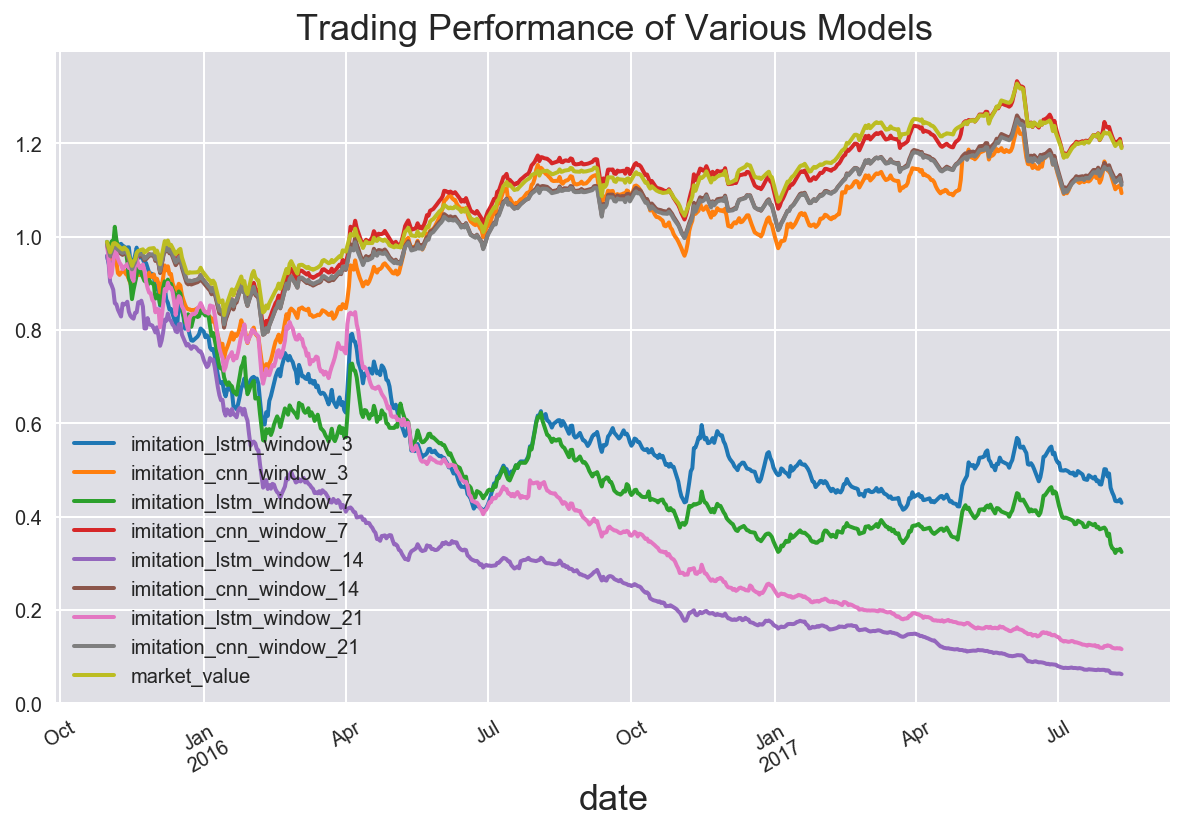

In [24]:
# test on CNN predictor, with batch norm and window length of 3
test_model_multiple(env, models[:8])

In [25]:
# evaluate the model with unseen data from same stock, fixed the starting date
env = MultiActionPortfolioEnv(testing_history, testing_stocks, model_names[8:], steps=650, start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

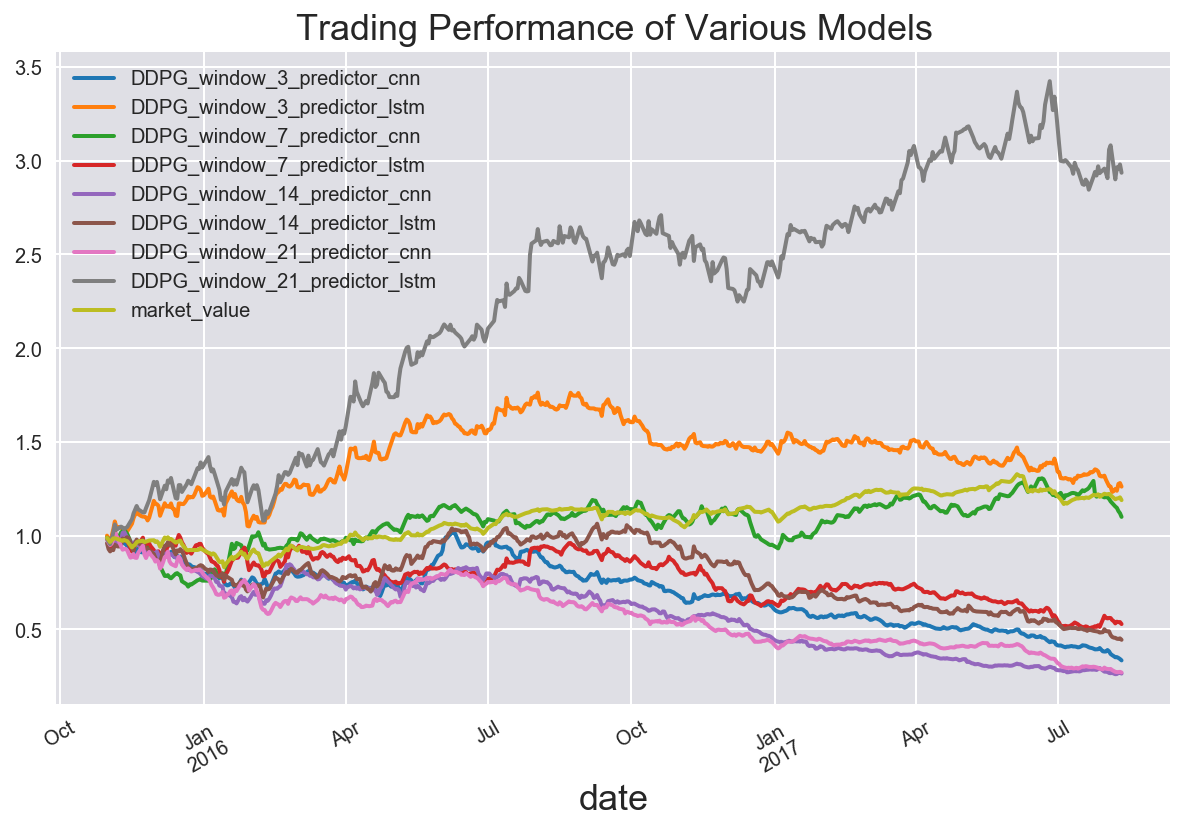

In [26]:
test_model_multiple(env, models[8:])

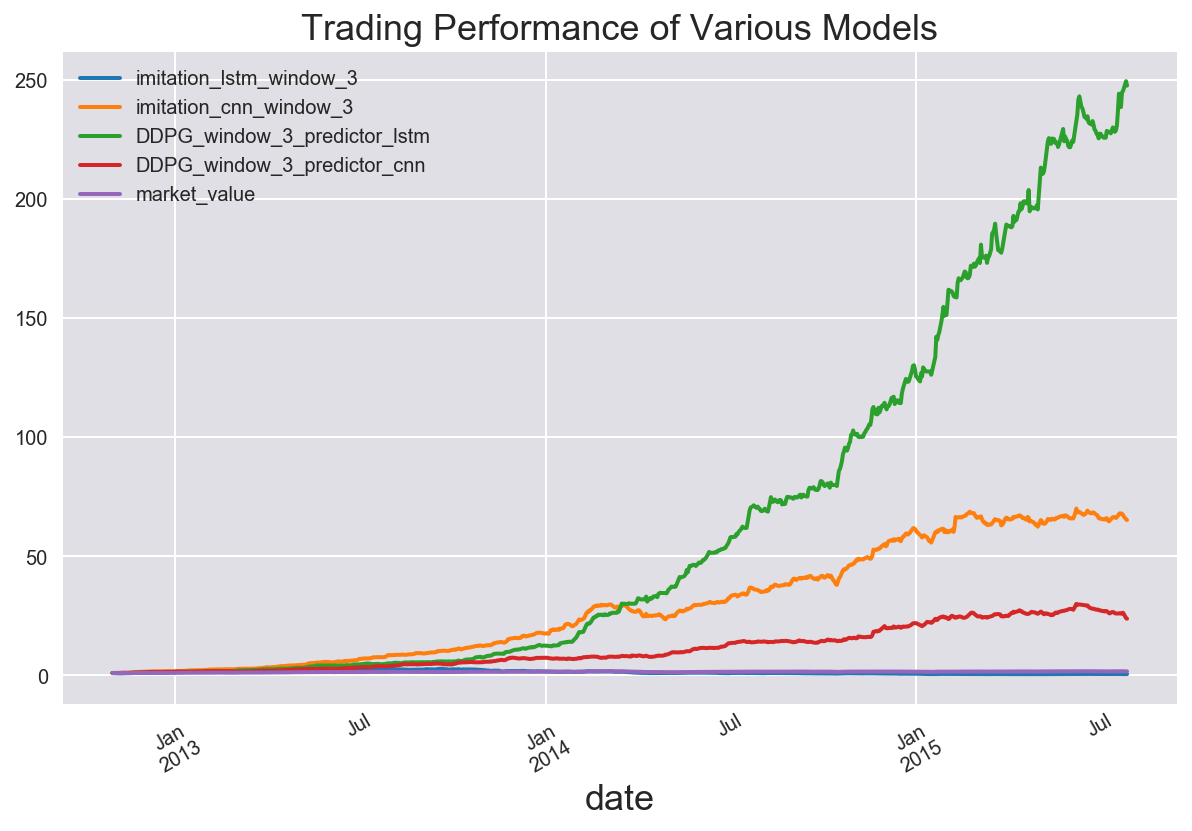

In [27]:
from environment.portfolio import MultiActionPortfolioEnv
selected_models = [models[0], models[1], models[9], models[8]]
selected_model_names = [model_names[0], model_names[1], model_names[9], model_names[8]]
env = MultiActionPortfolioEnv(target_history, target_stocks, selected_model_names, steps=1000, 
                              start_idx=0, sample_start_date='2012-10-30')
test_model_multiple(env, selected_models)

## Switch to KERAS
the mix od tflearn and Keras is creating problems: the code can not be run

In [59]:

from model.supervised.imitation_optimal_action import *

In [60]:
# test on imitation learning
optimal_given_past_model = create_network_give_past(nb_classes, 3, 
                                        weight_path='weights/stock/imitation_16_stocks.h5')

Build model from scratch


In [61]:
optimal_given_past_model.summary()
optimal_given_past_model.inputs
#optimal_given_past_model.save_weights(filepath='weights/stock/imitation_16_stocks.h5')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 17, 1, 32)         128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 17, 1, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 1, 32)         1056      
_________________________________________________________________
dropout_14 (Dropout)         (None, 17, 1, 32)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 544)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                34880     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
__________

[<tf.Tensor 'conv2d_7_input:0' shape=(?, 17, 3, 1) dtype=float32>]

In [62]:
testing_history.shape, num_training_time

((16, 730, 4), 1095)

In [98]:
# train
from environment.portfolio import PortfolioEnv
env = PortfolioEnv(testing_history, testing_stocks, steps=365, 
                   trading_cost=0.0025,
                   time_cost=0.00,
                   start_idx=10, 
                   sample_start_date='2012-10-30')

train_optimal_action_given_history_obs(optimal_given_past_model, target_history, target_stocks, 
                                       window_length = 3,
                                       weight_path='weights/stock/imitation_16_stocks.h5')



Train on 876 samples, validate on 216 samples
Epoch 1/1000
876/876 [==============================] - 0s 52us/step - loss: 1.3912 - acc: 0.5514 - val_loss: 3.3546 - val_acc: 0.1389
Epoch 2/1000
876/876 [==============================] - 0s 49us/step - loss: 1.3970 - acc: 0.5571 - val_loss: 3.3542 - val_acc: 0.1435
Epoch 3/1000
876/876 [==============================] - 0s 46us/step - loss: 1.4751 - acc: 0.5537 - val_loss: 3.3461 - val_acc: 0.1481
Epoch 4/1000
876/876 [==============================] - 0s 49us/step - loss: 1.4337 - acc: 0.5491 - val_loss: 3.3508 - val_acc: 0.1435
Epoch 5/1000
876/876 [==============================] - 0s 48us/step - loss: 1.3703 - acc: 0.5582 - val_loss: 3.3563 - val_acc: 0.1435
Epoch 6/1000
876/876 [==============================] - 0s 49us/step - loss: 1.4139 - acc: 0.5696 - val_loss: 3.3608 - val_acc: 0.1435
Epoch 7/1000
876/876 [==============================] - 0s 48us/step - loss: 1.3977 - acc: 0.5639 - val_loss: 3.3626 - val_acc: 0.1435
Epoch 8/1

Epoch 61/1000
876/876 [==============================] - 0s 45us/step - loss: 1.3180 - acc: 0.5753 - val_loss: 3.4119 - val_acc: 0.1435
Epoch 62/1000
876/876 [==============================] - 0s 45us/step - loss: 1.4910 - acc: 0.5274 - val_loss: 3.4024 - val_acc: 0.1389
Epoch 63/1000
876/876 [==============================] - 0s 45us/step - loss: 1.4286 - acc: 0.5502 - val_loss: 3.3883 - val_acc: 0.1343
Epoch 64/1000
876/876 [==============================] - 0s 45us/step - loss: 1.3617 - acc: 0.5331 - val_loss: 3.3909 - val_acc: 0.1389
Epoch 65/1000
876/876 [==============================] - 0s 46us/step - loss: 1.4210 - acc: 0.5457 - val_loss: 3.4002 - val_acc: 0.1389
Epoch 66/1000
876/876 [==============================] - 0s 44us/step - loss: 1.3974 - acc: 0.5548 - val_loss: 3.4166 - val_acc: 0.1389
Epoch 67/1000
876/876 [==============================] - 0s 44us/step - loss: 1.4125 - acc: 0.5605 - val_loss: 3.4278 - val_acc: 0.1296
Epoch 68/1000
876/876 [=========================

876/876 [==============================] - 0s 56us/step - loss: 1.3715 - acc: 0.5548 - val_loss: 3.4509 - val_acc: 0.1389
Epoch 122/1000
876/876 [==============================] - 0s 53us/step - loss: 1.3772 - acc: 0.5662 - val_loss: 3.4401 - val_acc: 0.1481
Epoch 123/1000
876/876 [==============================] - 0s 52us/step - loss: 1.4017 - acc: 0.5765 - val_loss: 3.4379 - val_acc: 0.1528
Epoch 124/1000
876/876 [==============================] - 0s 51us/step - loss: 1.3291 - acc: 0.5605 - val_loss: 3.4446 - val_acc: 0.1528
Epoch 125/1000
876/876 [==============================] - 0s 54us/step - loss: 1.4731 - acc: 0.5628 - val_loss: 3.4447 - val_acc: 0.1481
Epoch 126/1000
876/876 [==============================] - 0s 56us/step - loss: 1.3777 - acc: 0.5422 - val_loss: 3.4404 - val_acc: 0.1481
Epoch 127/1000
876/876 [==============================] - 0s 58us/step - loss: 1.3790 - acc: 0.5651 - val_loss: 3.4463 - val_acc: 0.1481
Epoch 128/1000
876/876 [==============================] 

Epoch 181/1000
876/876 [==============================] - 0s 55us/step - loss: 1.4191 - acc: 0.5228 - val_loss: 3.3809 - val_acc: 0.1343
Epoch 182/1000
876/876 [==============================] - 0s 49us/step - loss: 1.3931 - acc: 0.5696 - val_loss: 3.3787 - val_acc: 0.1343
Epoch 183/1000
876/876 [==============================] - 0s 51us/step - loss: 1.3178 - acc: 0.5594 - val_loss: 3.3863 - val_acc: 0.1389
Epoch 184/1000
876/876 [==============================] - 0s 48us/step - loss: 1.4140 - acc: 0.5422 - val_loss: 3.3896 - val_acc: 0.1435
Epoch 185/1000
876/876 [==============================] - 0s 52us/step - loss: 1.3355 - acc: 0.5742 - val_loss: 3.3951 - val_acc: 0.1435
Epoch 186/1000
876/876 [==============================] - 0s 59us/step - loss: 1.3498 - acc: 0.5491 - val_loss: 3.4074 - val_acc: 0.1389
Epoch 187/1000
876/876 [==============================] - 0s 55us/step - loss: 1.4155 - acc: 0.5639 - val_loss: 3.4121 - val_acc: 0.1389
Epoch 188/1000
876/876 [=================

Epoch 241/1000
876/876 [==============================] - 0s 49us/step - loss: 1.3397 - acc: 0.5788 - val_loss: 3.4310 - val_acc: 0.1343
Epoch 242/1000
876/876 [==============================] - 0s 51us/step - loss: 1.4451 - acc: 0.5548 - val_loss: 3.4387 - val_acc: 0.1343
Epoch 243/1000
876/876 [==============================] - 0s 53us/step - loss: 1.4098 - acc: 0.5445 - val_loss: 3.4267 - val_acc: 0.1343
Epoch 244/1000
876/876 [==============================] - 0s 54us/step - loss: 1.3881 - acc: 0.5651 - val_loss: 3.4273 - val_acc: 0.1343
Epoch 245/1000
876/876 [==============================] - 0s 50us/step - loss: 1.3979 - acc: 0.5377 - val_loss: 3.4482 - val_acc: 0.1296
Epoch 246/1000
876/876 [==============================] - 0s 53us/step - loss: 1.4203 - acc: 0.5537 - val_loss: 3.4457 - val_acc: 0.1250
Epoch 247/1000
876/876 [==============================] - 0s 61us/step - loss: 1.3877 - acc: 0.5514 - val_loss: 3.4444 - val_acc: 0.1250
Epoch 248/1000
876/876 [=================

Epoch 301/1000
876/876 [==============================] - 0s 49us/step - loss: 1.3707 - acc: 0.5616 - val_loss: 3.4230 - val_acc: 0.1296
Epoch 302/1000
876/876 [==============================] - 0s 50us/step - loss: 1.4012 - acc: 0.5616 - val_loss: 3.4198 - val_acc: 0.1296
Epoch 303/1000
876/876 [==============================] - 0s 52us/step - loss: 1.3434 - acc: 0.5674 - val_loss: 3.4354 - val_acc: 0.1296
Epoch 304/1000
876/876 [==============================] - 0s 54us/step - loss: 1.4008 - acc: 0.5514 - val_loss: 3.4393 - val_acc: 0.1250
Epoch 305/1000
876/876 [==============================] - 0s 57us/step - loss: 1.4214 - acc: 0.5491 - val_loss: 3.4443 - val_acc: 0.1250
Epoch 306/1000
876/876 [==============================] - 0s 54us/step - loss: 1.3526 - acc: 0.5696 - val_loss: 3.4527 - val_acc: 0.1250
Epoch 307/1000
876/876 [==============================] - 0s 61us/step - loss: 1.4362 - acc: 0.5434 - val_loss: 3.4483 - val_acc: 0.1250
Epoch 308/1000
876/876 [=================

Epoch 361/1000
876/876 [==============================] - 0s 54us/step - loss: 1.4050 - acc: 0.5525 - val_loss: 3.4006 - val_acc: 0.1389
Epoch 362/1000
876/876 [==============================] - 0s 60us/step - loss: 1.3651 - acc: 0.5616 - val_loss: 3.4063 - val_acc: 0.1389
Epoch 363/1000
876/876 [==============================] - 0s 59us/step - loss: 1.4522 - acc: 0.5537 - val_loss: 3.4100 - val_acc: 0.1343
Epoch 364/1000
876/876 [==============================] - 0s 62us/step - loss: 1.4523 - acc: 0.5605 - val_loss: 3.4114 - val_acc: 0.1343
Epoch 365/1000
876/876 [==============================] - 0s 63us/step - loss: 1.4684 - acc: 0.5502 - val_loss: 3.4094 - val_acc: 0.1343
Epoch 366/1000
876/876 [==============================] - 0s 59us/step - loss: 1.3741 - acc: 0.5582 - val_loss: 3.4031 - val_acc: 0.1343
Epoch 367/1000
876/876 [==============================] - 0s 61us/step - loss: 1.4734 - acc: 0.5491 - val_loss: 3.4126 - val_acc: 0.1343
Epoch 368/1000
876/876 [=================

Epoch 421/1000
876/876 [==============================] - 0s 55us/step - loss: 1.4181 - acc: 0.5342 - val_loss: 3.4230 - val_acc: 0.1389
Epoch 422/1000
876/876 [==============================] - 0s 57us/step - loss: 1.3610 - acc: 0.5628 - val_loss: 3.4148 - val_acc: 0.1389
Epoch 423/1000
876/876 [==============================] - 0s 56us/step - loss: 1.3381 - acc: 0.5696 - val_loss: 3.4143 - val_acc: 0.1389
Epoch 424/1000
876/876 [==============================] - 0s 56us/step - loss: 1.4107 - acc: 0.5571 - val_loss: 3.4091 - val_acc: 0.1389
Epoch 425/1000
876/876 [==============================] - 0s 56us/step - loss: 1.4050 - acc: 0.5639 - val_loss: 3.4126 - val_acc: 0.1296
Epoch 426/1000
876/876 [==============================] - 0s 58us/step - loss: 1.3619 - acc: 0.5571 - val_loss: 3.4291 - val_acc: 0.1343
Epoch 427/1000
876/876 [==============================] - 0s 58us/step - loss: 1.3965 - acc: 0.5639 - val_loss: 3.4437 - val_acc: 0.1343
Epoch 428/1000
876/876 [=================

Epoch 481/1000
876/876 [==============================] - 0s 49us/step - loss: 1.4767 - acc: 0.5217 - val_loss: 3.4418 - val_acc: 0.1343
Epoch 482/1000
876/876 [==============================] - 0s 52us/step - loss: 1.3728 - acc: 0.5674 - val_loss: 3.4235 - val_acc: 0.1389
Epoch 483/1000
876/876 [==============================] - 0s 53us/step - loss: 1.4090 - acc: 0.5537 - val_loss: 3.4413 - val_acc: 0.1296
Epoch 484/1000
876/876 [==============================] - 0s 51us/step - loss: 1.3799 - acc: 0.5491 - val_loss: 3.4781 - val_acc: 0.1343
Epoch 485/1000
876/876 [==============================] - 0s 49us/step - loss: 1.3470 - acc: 0.5651 - val_loss: 3.4895 - val_acc: 0.1343
Epoch 486/1000
876/876 [==============================] - 0s 50us/step - loss: 1.4119 - acc: 0.5628 - val_loss: 3.4818 - val_acc: 0.1343
Epoch 487/1000
876/876 [==============================] - 0s 50us/step - loss: 1.3200 - acc: 0.5856 - val_loss: 3.4727 - val_acc: 0.1389
Epoch 488/1000
876/876 [=================

Epoch 541/1000
876/876 [==============================] - 0s 47us/step - loss: 1.3295 - acc: 0.5731 - val_loss: 3.4659 - val_acc: 0.1296
Epoch 542/1000
876/876 [==============================] - 0s 47us/step - loss: 1.4113 - acc: 0.5514 - val_loss: 3.4753 - val_acc: 0.1250
Epoch 543/1000
876/876 [==============================] - 0s 45us/step - loss: 1.4223 - acc: 0.5605 - val_loss: 3.4755 - val_acc: 0.1204
Epoch 544/1000
876/876 [==============================] - 0s 45us/step - loss: 1.4198 - acc: 0.5434 - val_loss: 3.4756 - val_acc: 0.1204
Epoch 545/1000
876/876 [==============================] - 0s 45us/step - loss: 1.4370 - acc: 0.5514 - val_loss: 3.4751 - val_acc: 0.1204
Epoch 546/1000
876/876 [==============================] - 0s 46us/step - loss: 1.4032 - acc: 0.5354 - val_loss: 3.4685 - val_acc: 0.1250
Epoch 547/1000
876/876 [==============================] - 0s 45us/step - loss: 1.3502 - acc: 0.5753 - val_loss: 3.4611 - val_acc: 0.1296
Epoch 548/1000
876/876 [=================

Epoch 601/1000
876/876 [==============================] - 0s 50us/step - loss: 1.3706 - acc: 0.5582 - val_loss: 3.3980 - val_acc: 0.1389
Epoch 602/1000
876/876 [==============================] - 0s 50us/step - loss: 1.3331 - acc: 0.5719 - val_loss: 3.3948 - val_acc: 0.1343
Epoch 603/1000
876/876 [==============================] - 0s 49us/step - loss: 1.3595 - acc: 0.5719 - val_loss: 3.4142 - val_acc: 0.1343
Epoch 604/1000
876/876 [==============================] - 0s 50us/step - loss: 1.3919 - acc: 0.5594 - val_loss: 3.4346 - val_acc: 0.1343
Epoch 605/1000
876/876 [==============================] - 0s 49us/step - loss: 1.4176 - acc: 0.5388 - val_loss: 3.4449 - val_acc: 0.1343
Epoch 606/1000
876/876 [==============================] - 0s 49us/step - loss: 1.4095 - acc: 0.5354 - val_loss: 3.4357 - val_acc: 0.1343
Epoch 607/1000
876/876 [==============================] - 0s 54us/step - loss: 1.4668 - acc: 0.5331 - val_loss: 3.4394 - val_acc: 0.1343
Epoch 608/1000
876/876 [=================

Epoch 661/1000
876/876 [==============================] - 0s 51us/step - loss: 1.4085 - acc: 0.5559 - val_loss: 3.4527 - val_acc: 0.1250
Epoch 662/1000
876/876 [==============================] - 0s 53us/step - loss: 1.3079 - acc: 0.5788 - val_loss: 3.4512 - val_acc: 0.1296
Epoch 663/1000
876/876 [==============================] - 0s 46us/step - loss: 1.3438 - acc: 0.5822 - val_loss: 3.4507 - val_acc: 0.1296
Epoch 664/1000
876/876 [==============================] - 0s 50us/step - loss: 1.4921 - acc: 0.5502 - val_loss: 3.4456 - val_acc: 0.1296
Epoch 665/1000
876/876 [==============================] - 0s 48us/step - loss: 1.3852 - acc: 0.5571 - val_loss: 3.4333 - val_acc: 0.1296
Epoch 666/1000
876/876 [==============================] - 0s 48us/step - loss: 1.3513 - acc: 0.5468 - val_loss: 3.4436 - val_acc: 0.1296
Epoch 667/1000
876/876 [==============================] - 0s 49us/step - loss: 1.4128 - acc: 0.5320 - val_loss: 3.4521 - val_acc: 0.1250
Epoch 668/1000
876/876 [=================

Epoch 721/1000
876/876 [==============================] - 0s 57us/step - loss: 1.3847 - acc: 0.5605 - val_loss: 3.4236 - val_acc: 0.1435
Epoch 722/1000
876/876 [==============================] - 0s 58us/step - loss: 1.2789 - acc: 0.5845 - val_loss: 3.4200 - val_acc: 0.1389
Epoch 723/1000
876/876 [==============================] - 0s 60us/step - loss: 1.3601 - acc: 0.5651 - val_loss: 3.4284 - val_acc: 0.1481
Epoch 724/1000
876/876 [==============================] - 0s 58us/step - loss: 1.4267 - acc: 0.5422 - val_loss: 3.4254 - val_acc: 0.1389
Epoch 725/1000
876/876 [==============================] - 0s 47us/step - loss: 1.4833 - acc: 0.5285 - val_loss: 3.4126 - val_acc: 0.1343
Epoch 726/1000
876/876 [==============================] - 0s 50us/step - loss: 1.3537 - acc: 0.5811 - val_loss: 3.4102 - val_acc: 0.1343
Epoch 727/1000
876/876 [==============================] - 0s 46us/step - loss: 1.3801 - acc: 0.5594 - val_loss: 3.4293 - val_acc: 0.1389
Epoch 728/1000
876/876 [=================

Epoch 781/1000
876/876 [==============================] - 0s 52us/step - loss: 1.3952 - acc: 0.5674 - val_loss: 3.4545 - val_acc: 0.1296
Epoch 782/1000
876/876 [==============================] - 0s 51us/step - loss: 1.3605 - acc: 0.5605 - val_loss: 3.4600 - val_acc: 0.1296
Epoch 783/1000
876/876 [==============================] - 0s 52us/step - loss: 1.4055 - acc: 0.5628 - val_loss: 3.4541 - val_acc: 0.1250
Epoch 784/1000
876/876 [==============================] - 0s 54us/step - loss: 1.3756 - acc: 0.5628 - val_loss: 3.4393 - val_acc: 0.1250
Epoch 785/1000
876/876 [==============================] - 0s 53us/step - loss: 1.4446 - acc: 0.5616 - val_loss: 3.4243 - val_acc: 0.1250
Epoch 786/1000
876/876 [==============================] - 0s 53us/step - loss: 1.3515 - acc: 0.5696 - val_loss: 3.4366 - val_acc: 0.1296
Epoch 787/1000
876/876 [==============================] - 0s 49us/step - loss: 1.3434 - acc: 0.5548 - val_loss: 3.4490 - val_acc: 0.1296
Epoch 788/1000
876/876 [=================

Epoch 841/1000
876/876 [==============================] - 0s 62us/step - loss: 1.3453 - acc: 0.5708 - val_loss: 3.4485 - val_acc: 0.1296
Epoch 842/1000
876/876 [==============================] - 0s 56us/step - loss: 1.3873 - acc: 0.5662 - val_loss: 3.4482 - val_acc: 0.1296
Epoch 843/1000
876/876 [==============================] - 0s 49us/step - loss: 1.4370 - acc: 0.5582 - val_loss: 3.4451 - val_acc: 0.1343
Epoch 844/1000
876/876 [==============================] - 0s 50us/step - loss: 1.4759 - acc: 0.5411 - val_loss: 3.4390 - val_acc: 0.1296
Epoch 845/1000
876/876 [==============================] - 0s 47us/step - loss: 1.3722 - acc: 0.5559 - val_loss: 3.4328 - val_acc: 0.1250
Epoch 846/1000
876/876 [==============================] - 0s 51us/step - loss: 1.4429 - acc: 0.5354 - val_loss: 3.4387 - val_acc: 0.1250
Epoch 847/1000
876/876 [==============================] - 0s 48us/step - loss: 1.3767 - acc: 0.5616 - val_loss: 3.4346 - val_acc: 0.1250
Epoch 848/1000
876/876 [=================

Epoch 901/1000
876/876 [==============================] - 0s 53us/step - loss: 1.4155 - acc: 0.5468 - val_loss: 3.4361 - val_acc: 0.1343
Epoch 902/1000
876/876 [==============================] - 0s 53us/step - loss: 1.4388 - acc: 0.5194 - val_loss: 3.4408 - val_acc: 0.1296
Epoch 903/1000
876/876 [==============================] - 0s 52us/step - loss: 1.5050 - acc: 0.5320 - val_loss: 3.4360 - val_acc: 0.1343
Epoch 904/1000
876/876 [==============================] - 0s 55us/step - loss: 1.3742 - acc: 0.5400 - val_loss: 3.4351 - val_acc: 0.1343
Epoch 905/1000
876/876 [==============================] - 0s 52us/step - loss: 1.4216 - acc: 0.5594 - val_loss: 3.4180 - val_acc: 0.1389
Epoch 906/1000
876/876 [==============================] - 0s 48us/step - loss: 1.3736 - acc: 0.5639 - val_loss: 3.4235 - val_acc: 0.1296
Epoch 907/1000
876/876 [==============================] - 0s 50us/step - loss: 1.4170 - acc: 0.5434 - val_loss: 3.4374 - val_acc: 0.1343
Epoch 908/1000
876/876 [=================

Epoch 961/1000
876/876 [==============================] - 0s 51us/step - loss: 1.3966 - acc: 0.5594 - val_loss: 3.4022 - val_acc: 0.1343
Epoch 962/1000
876/876 [==============================] - 0s 54us/step - loss: 1.3717 - acc: 0.5594 - val_loss: 3.4049 - val_acc: 0.1250
Epoch 963/1000
876/876 [==============================] - 0s 57us/step - loss: 1.3111 - acc: 0.5708 - val_loss: 3.4099 - val_acc: 0.1250
Epoch 964/1000
876/876 [==============================] - 0s 54us/step - loss: 1.3954 - acc: 0.5651 - val_loss: 3.4338 - val_acc: 0.1250
Epoch 965/1000
876/876 [==============================] - 0s 52us/step - loss: 1.4680 - acc: 0.5468 - val_loss: 3.4432 - val_acc: 0.1250
Epoch 966/1000
876/876 [==============================] - 0s 50us/step - loss: 1.3407 - acc: 0.5708 - val_loss: 3.4565 - val_acc: 0.1296
Epoch 967/1000
876/876 [==============================] - 0s 50us/step - loss: 1.3887 - acc: 0.5753 - val_loss: 3.4584 - val_acc: 0.1296
Epoch 968/1000
876/876 [=================

In [99]:
print("ss",env.action_space, env.action_space.sample())

ss Box(17,) [0.57432526 0.6532008  0.65210325 0.43141845 0.8965466  0.36756188
 0.43586493 0.89192337 0.806194   0.7038886  0.10022689 0.9194826
 0.7142413  0.998847   0.1494483  0.86812603 0.16249293]


In [107]:
from environment.portfolio import PortfolioEnv
env = PortfolioEnv(testing_history, testing_stocks, steps=365, 
                   trading_cost=0.0015,
                   time_cost=0.00,
                   start_idx=num_training_time, 
                   sample_start_date='2015-10-30')

DTYPE 1  float32 float32


/Users/raphaelbiojout/code/drl-portfolio-management/src/environment/portfolio.py:43: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  trough = returns[returns.argmax():].min()


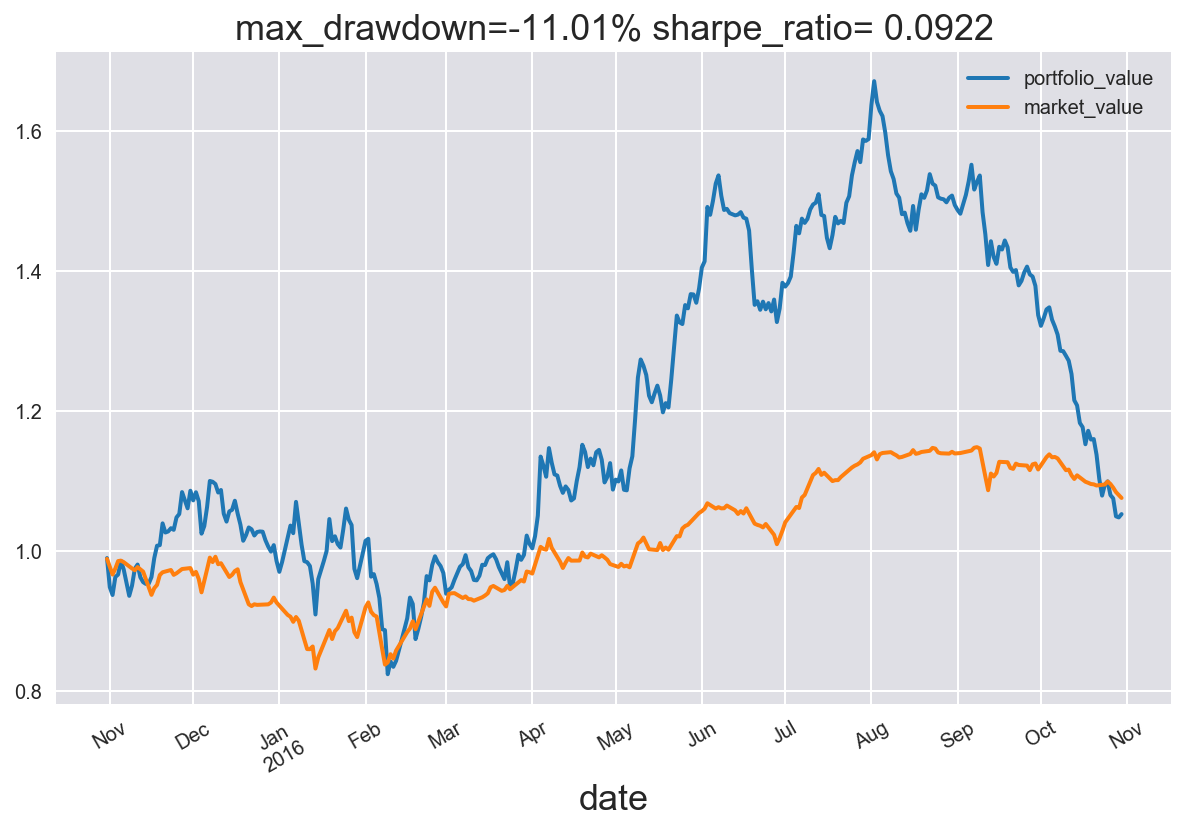

In [108]:
done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
close_open_ratio = normalize(close_open_ratio)
while not done:
    action = np.zeros((nb_classes,))
    close_open_ratio = close_open_ratio[:, -3:]
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    current_action_index = optimal_given_past_model.predict_classes(close_open_ratio, verbose=0)
    action[current_action_index] = 1.0
    observation, reward, done, _ = env.step(action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
    close_open_ratio = normalize(close_open_ratio)
env.render()
# optimal_given_past_model.save_weights('weights/stock/imitation_16_stocks.h5')

In [91]:
testing_stocks

['AAPL',
 'ATVI',
 'CMCSA',
 'COST',
 'CSX',
 'DISH',
 'EA',
 'EBAY',
 'FB',
 'GOOGL',
 'HAS',
 'ILMN',
 'INTC',
 'MAR',
 'REGN',
 'SBUX']

In [92]:
df_info = env.df_info()
df_info.describe()
df_info.tail()

change   change_AAPL  \
date                                                                          
2016-10-26  [-1.3005966698229938e-10, 0.0, 0.0, 0.0, 0.0, ...  0.000000e+00   
2016-10-27  [-2.876811346577029e-11, 0.0, 0.0, 0.0, 0.0, 0...  0.000000e+00   
2016-10-28  [-1.6513320112811514e-10, 0.0, 0.6255683703729...  0.000000e+00   
2016-10-29  [-3.9438811631848154e-11, 0.6216244891814178, ...  5.466272e-03   
2016-10-30  [-8.188690440940936e-12, 8.179013022413528e-12...  7.192238e-14   

            change_ATVI  change_CMCSA  change_COST  change_CSX  change_DISH  \
date                                                                          
2016-10-26     0.000000           0.0          0.0         0.0          0.0   
2016-10-27     0.000000           0.0          0.0         0.0          0.0   
2016-10-28     0.014309           0.0          0.0         0.0          0.0   
2016-10-29    -0.014335           0.0          0.0         0.0          0.0   
2016-10-30     0.000000           0.0          0.0         0.0          0.0   

               change_EA  change_EBAY  change_FB     ...       weight_GOOGL  \
date                                                 ...                      
2016-10-26  7.776205e-03          0.0  -0.004929     ...                0.0   
2016-10-27  3.482454e-13          0.0   0.000000     ...                0.0   
2016-10-28 -7.709915e-03          0.0   0.000000     ...                0.0   
2016-10-29  0.000000e+00          0.0   0.000000     ...                0.0   
2016-10-30  0.000000e+00          0.0   0.000000     ...                0.0   

            weight_HAS  weight_ILMN  weight_INTC  weight_MAR  weight_REGN  \
date                                                                        
2016-10-26         0.0          0.0          0.0         0.0          0.0   
2016-10-27         0.0          0.0          0.0         0.0          0.0   
2016-10-28         0.0          0.0          0.0         0.0          0.0   
2016-10-29         0.0          0.0          0.0         0.0          0.0   
2016-10-30         0.0          0.0          0.0         0.0          0.0   

            weight_SBUX   weight_cash weights_mean  weights_std  
date                                                             
2016-10-26          0.0  1.000000e-08     0.058824     0.235294  
2016-10-27          0.0  1.000000e-08     0.058824     0.235294  
2016-10-28          0.0  1.000000e-08     0.058824     0.235294  
2016-10-29          0.0  1.000000e-08     0.058824     0.235294  
2016-10-30          0.0  1.000000e-08     0.058824     0.235294  

[5 rows x 69 columns]

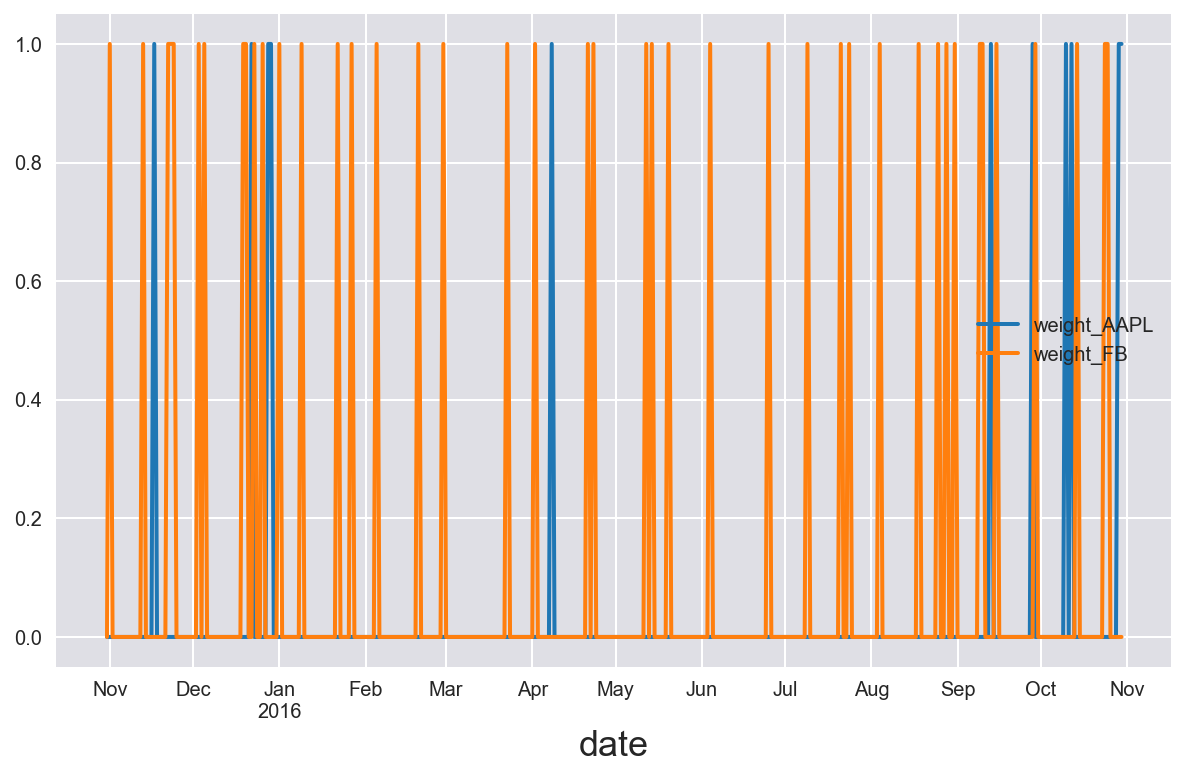

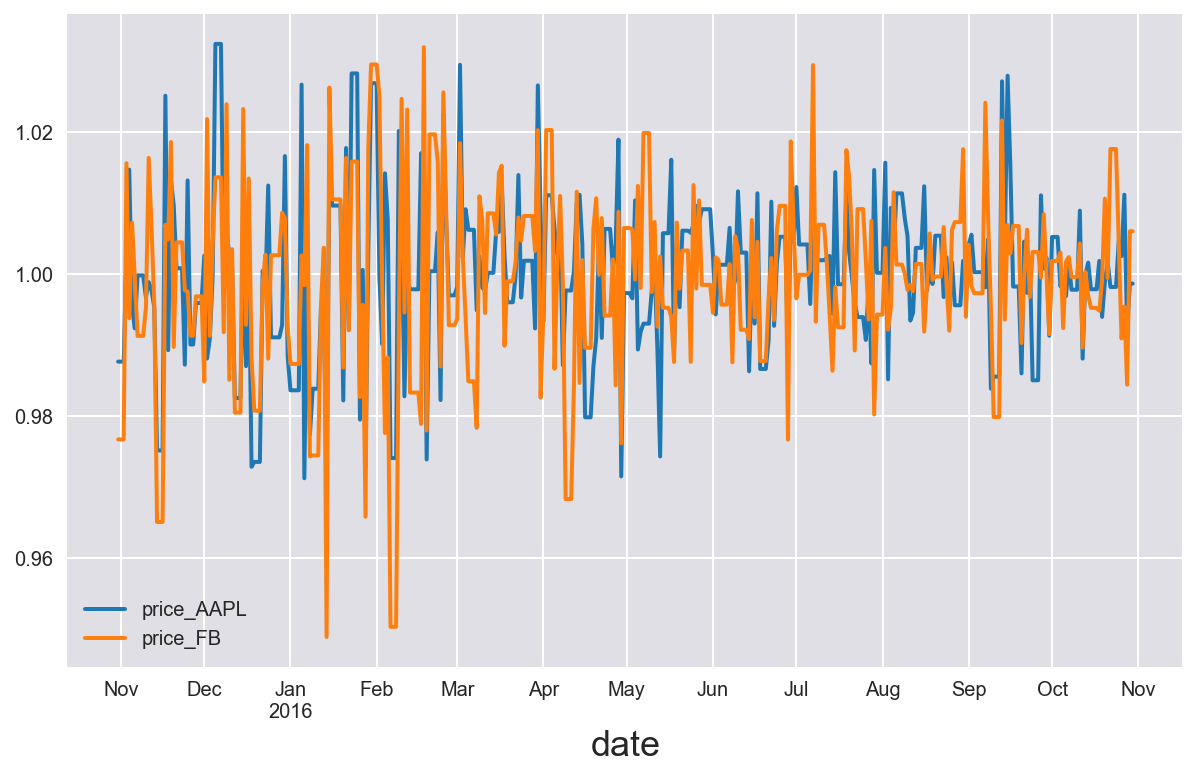

In [93]:
df_info[['weight_AAPL', 'weight_FB']].plot()
df_info[['price_AAPL', 'price_FB']].plot()

In [126]:
# create another dataset
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target_2.h5')
history = history[:, :, :4]
nb_classes = len(history) + 1
print(history.shape)
testing_history = history
testing_stocks = abbreviation
target_history = history
target_stocks = abbreviation

(16, 1825, 4)
